In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

PATH = "drive/MyDrive/"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Additional datasets merging

First, we load the additional datasets:

In [ ]:
df = pd.read_parquet(PATH + "Project datasets/speaker_attributes.parquet/part-00001-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet", engine='pyarrow')
df

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,None,None,None,[Q6581097],985453603,None,None,None,None,None,Q45441526,Cui Yan,None,item,None
1,None,None,[Q9903],[Q6581097],1008699604,None,None,None,None,None,Q45441555,Guo Ziyi,None,item,None
2,None,None,[Q9903],[Q6581097],1008699709,None,None,None,None,None,Q45441562,Wan Zikui,None,item,None
3,None,None,[Q9903],[Q6581097],1008699728,None,None,None,None,None,Q45441563,Lin Pei,None,item,None
4,None,None,[Q9683],[Q6581097],985261661,None,None,None,None,None,Q45441565,Guan Zhen,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660353,None,None,None,None,1388244101,None,None,None,None,None,Q106134191,Leonhard Gans,None,item,None
660354,None,None,None,None,1388243838,None,None,None,None,None,Q106134200,André de Arena,None,item,None
660355,None,None,None,None,1388243780,None,None,None,None,None,Q106134203,Andreas Byssmann,None,item,None
660356,None,None,None,None,1388243759,None,None,None,None,None,Q106134204,Johannes,None,item,None


Here we define the necessary functions to prepare the data:

In [ ]:
def Qids_to_tuple_words(tuple_qids, wikidata_labels):
    words = []
    for qid in tuple_qids:
        try:
	          words.append(wikidata_labels.loc[qid]['Label'])
        except:
            pass
    return tuple(words)

def Qids_to_words(df, column_name, wikidata_labels):
    df_c = df[column_name][df[column_name].notna()].copy()
    df_c = df_c.apply(lambda x: Qids_to_tuple_words(np.sort(x), wikidata_labels))
    return df_c

Loading the dataset with descriptions:

In [ ]:
wikidata_labels = pd.read_csv(PATH + 'Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
wikidata_labels

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America
...,...,...
Q106302506,didgeridooist,musician who plays the didgeridoo
Q106341153,biochemistry teacher,teacher of biochemistry at any level
Q106368830,2018 Wigan Metropolitan Borough Council electi...,NaN


Creating the dataframe containing id of the person, name and occupation:

In [ ]:
#getting occupations
occupations = Qids_to_words(df, 'occupation', wikidata_labels)

In [ ]:
#merging with persons data
df_name_occup = df[['id', 'label']].join(occupations)
df_name_occup

,id,label,occupation
0,Q45441526,Cui Yan,NaN
1,Q45441555,Guo Ziyi,NaN
2,Q45441562,Wan Zikui,NaN
3,Q45441563,Lin Pei,NaN
4,Q45441565,Guan Zhen,NaN
...,...,...,...
660353,Q106134191,Leonhard Gans,NaN
660354,Q106134200,André de Arena,NaN
660355,Q106134203,Andreas Byssmann,NaN
660356,Q106134204,Johannes,NaN


Dropping NaN values from df:

In [ ]:
df_name_occup = df_name_occup.dropna()
df_name_occup

,id,label,occupation
16,Q45441690,Joachim Beige,"(researcher,)"
60,Q45442113,Wang Zhuo,"(poet,)"
71,Q45442210,Guo Tingxun,"(politician,)"
210,Q45443368,Wang Zhu,"(poet,)"
280,Q45444005,Wu Yunqian,"(politician,)"
...,...,...,...
660340,Q106132792,James E. Barber,"(physician,)"
660341,Q106133082,Ulrik Lehrmann,"(researcher,)"
660342,Q106133269,Vera Boyadzhieva-Fol,"(activist, journalist, school teacher, writer,..."
660343,Q106133600,Eduard Herman van Rees,"(military officer,)"


Getting the occupations number for each person:

In [ ]:
df_name_occup['num_of_occup'] = df_name_occup['occupation'].apply(lambda x: len(x))
df_name_occup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,label,occupation,num_of_occup
16,Q45441690,Joachim Beige,"(researcher,)",1
60,Q45442113,Wang Zhuo,"(poet,)",1
71,Q45442210,Guo Tingxun,"(politician,)",1
210,Q45443368,Wang Zhu,"(poet,)",1
280,Q45444005,Wu Yunqian,"(politician,)",1
...,...,...,...,...
660340,Q106132792,James E. Barber,"(physician,)",1
660341,Q106133082,Ulrik Lehrmann,"(researcher,)",1
660342,Q106133269,Vera Boyadzhieva-Fol,"(activist, journalist, school teacher, writer,...",5
660343,Q106133600,Eduard Herman van Rees,"(military officer,)",1


Here we drop the rows with more than one occupation because we would need to train our model with distinct value. After, we may test our results on persons who changed their professions during years.

In [ ]:
df_name_occup_copy = df_name_occup.drop(df_name_occup[df_name_occup.num_of_occup != 1].index)
df_name_occup_copy

,id,label,occupation,num_of_occup
16,Q45441690,Joachim Beige,"(researcher,)",1
60,Q45442113,Wang Zhuo,"(poet,)",1
71,Q45442210,Guo Tingxun,"(politician,)",1
210,Q45443368,Wang Zhu,"(poet,)",1
280,Q45444005,Wu Yunqian,"(politician,)",1
...,...,...,...,...
660336,Q106131035,Ron Anderson,"(voice teacher,)",1
660337,Q106131144,Jakub Nečas,"(basketball player,)",1
660340,Q106132792,James E. Barber,"(physician,)",1
660341,Q106133082,Ulrik Lehrmann,"(researcher,)",1


Don't need the counter any more

In [ ]:
#dropping counter
df_name_occup_copy = df_name_occup_copy.drop(columns=['num_of_occup'])
df_name_occup_copy

,id,label,occupation
16,Q45441690,Joachim Beige,"(researcher,)"
60,Q45442113,Wang Zhuo,"(poet,)"
71,Q45442210,Guo Tingxun,"(politician,)"
210,Q45443368,Wang Zhu,"(poet,)"
280,Q45444005,Wu Yunqian,"(politician,)"
...,...,...,...
660336,Q106131035,Ron Anderson,"(voice teacher,)"
660337,Q106131144,Jakub Nečas,"(basketball player,)"
660340,Q106132792,James E. Barber,"(physician,)"
660341,Q106133082,Ulrik Lehrmann,"(researcher,)"


Casting the occupation to proper(for future clustering) data type. 

In [ ]:
df_name_occup_copy['occupation'] = df_name_occup_copy['occupation'].apply(lambda x: str(x[0]))
df_name_occup_copy['occupation'] = df_name_occup_copy['occupation'].astype("string")
df_name_occup_copy

,id,label,occupation
16,Q45441690,Joachim Beige,researcher
60,Q45442113,Wang Zhuo,poet
71,Q45442210,Guo Tingxun,politician
210,Q45443368,Wang Zhu,poet
280,Q45444005,Wu Yunqian,politician
...,...,...,...
660336,Q106131035,Ron Anderson,voice teacher
660337,Q106131144,Jakub Nečas,basketball player
660340,Q106132792,James E. Barber,physician
660341,Q106133082,Ulrik Lehrmann,researcher


Now we may do it for all the presented additional datasets:

In [ ]:
#function to convert additional datasets to proper one(seen in the cell above)
def make_dataframe_with_names_and_occups():
    PATH = "drive/MyDrive/"
    wikidata_labels = pd.read_csv(PATH + 'Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
    df_name_occup = None

    for i in range(16):
        print("Reading " + f"{i+1}/16")
        file_name = "Project datasets/speaker_attributes.parquet/part-" + f"{i:05}" + "-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet"
        df = pd.read_parquet(PATH + file_name, engine='pyarrow')
        occupations = Qids_to_words(df, 'occupation', wikidata_labels)
        df_n_o = df[['id', 'label']].join(occupations)
        df_n_o = df_n_o.dropna()
        try:
	          df_name_occup = pd.concat([df_name_occup, df_n_o], ignore_index=True)
        except:
	          df_name_occup = df_n_o.copy()
    
    df_name_occup['label'] = df_name_occup['label'].astype("string")

    return df_name_occup.copy()

In [ ]:
#creating single dataset
df_name_occup = make_dataframe_with_names_and_occups()

#saving it as pkl file
df_name_occup.to_pickle(PATH+"df_name_occup.zip")
output = pd.read_pickle(PATH+"df_name_occup.zip")
output

Reading 1/16
Reading 2/16
Reading 3/16
Reading 4/16
Reading 5/16
Reading 6/16
Reading 7/16
Reading 8/16
Reading 9/16
Reading 10/16
Reading 11/16
Reading 12/16
Reading 13/16
Reading 14/16
Reading 15/16
Reading 16/16


,id,label,occupation
0,Q23,George Washington,"(slaveholder, farmer, cartographer, military o..."
1,Q42,Douglas Adams,"(science fiction writer, playwright, comedian,..."
2,Q1868,Paul Otlet,"(bibliographer, information scientist, librari..."
3,Q207,George W. Bush,"(painter, rugby union player, motivational spe..."
4,Q297,Diego Velázquez,"(painter,)"
...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,"(politician,)"
6073733,Q106406557,Andrew F. Healy,"(politician,)"
6073734,Q106406560,Barker B. Howard,"(politician,)"
6073735,Q106406571,Charles H. Macomber,"(politician,)"


In [ ]:
#reading the pkl
output = pd.read_pickle(PATH+"df_name_occup.zip")
output

,id,label,occupation
0,Q23,George Washington,"(slaveholder, farmer, cartographer, military o..."
1,Q42,Douglas Adams,"(science fiction writer, playwright, comedian,..."
2,Q1868,Paul Otlet,"(bibliographer, information scientist, librari..."
3,Q207,George W. Bush,"(painter, rugby union player, motivational spe..."
4,Q297,Diego Velázquez,"(painter,)"
...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,"(politician,)"
6073733,Q106406557,Andrew F. Healy,"(politician,)"
6073734,Q106406560,Barker B. Howard,"(politician,)"
6073735,Q106406571,Charles H. Macomber,"(politician,)"


Some cleaning: Getting only distinct occupations and casting them to proper datatype(string)

In [ ]:
#counting occupations
output['num'] =  output['occupation'].apply(lambda x: len(x))
output

,id,label,occupation,num
0,Q23,George Washington,"(slaveholder, farmer, cartographer, military o...",8
1,Q42,Douglas Adams,"(science fiction writer, playwright, comedian,...",7
2,Q1868,Paul Otlet,"(bibliographer, information scientist, librari...",6
3,Q207,George W. Bush,"(painter, rugby union player, motivational spe...",9
4,Q297,Diego Velázquez,"(painter,)",1
...,...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,"(politician,)",1
6073733,Q106406557,Andrew F. Healy,"(politician,)",1
6073734,Q106406560,Barker B. Howard,"(politician,)",1
6073735,Q106406571,Charles H. Macomber,"(politician,)",1


In [ ]:
#selecting only distinct ones
output_copy = output.drop(output[output.num != 1].index)
output_copy

,id,label,occupation,num
4,Q297,Diego Velázquez,"(painter,)",1
19,Q1149,Indira Gandhi,"(politician,)",1
29,Q1416,Otho,"(politician,)",1
32,Q1526,Ramesses I,"(sovereign,)",1
33,Q1638,Primo Nebiolo,"(sports official,)",1
...,...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,"(politician,)",1
6073733,Q106406557,Andrew F. Healy,"(politician,)",1
6073734,Q106406560,Barker B. Howard,"(politician,)",1
6073735,Q106406571,Charles H. Macomber,"(politician,)",1


In [ ]:
#drop the counter column
output_copy = output_copy.drop(columns=['num'])
output_copy

,id,label,occupation
4,Q297,Diego Velázquez,"(painter,)"
19,Q1149,Indira Gandhi,"(politician,)"
29,Q1416,Otho,"(politician,)"
32,Q1526,Ramesses I,"(sovereign,)"
33,Q1638,Primo Nebiolo,"(sports official,)"
...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,"(politician,)"
6073733,Q106406557,Andrew F. Healy,"(politician,)"
6073734,Q106406560,Barker B. Howard,"(politician,)"
6073735,Q106406571,Charles H. Macomber,"(politician,)"


In [ ]:
#converting occupations to string
output_copy['occupation'] = output_copy['occupation'].apply(lambda x: str(x[0]))
output_copy['occupation'] = output_copy['occupation'].astype("string")
output_copy

,id,label,occupation
4,Q297,Diego Velázquez,painter
19,Q1149,Indira Gandhi,politician
29,Q1416,Otho,politician
32,Q1526,Ramesses I,sovereign
33,Q1638,Primo Nebiolo,sports official
...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,politician
6073733,Q106406557,Andrew F. Healy,politician
6073734,Q106406560,Barker B. Howard,politician
6073735,Q106406571,Charles H. Macomber,politician


Next, the above dataset is sent to Mohamed to do the clustering.

# 4 clusters

Before we will have the merged clusters from the occupations we created on the previous step, we decided to check if our model will work with at least four clusters chosen "by hand".

First, we read the pkl occupation file and make sofe cleaning steps:

In [ ]:
#reading data
output = pd.read_pickle('/content/drive/MyDrive/df_name_occup.zip')
output.head(5)

,id,label,occupation
0,Q23,George Washington,"(slaveholder, farmer, cartographer, military o..."
1,Q42,Douglas Adams,"(science fiction writer, playwright, comedian,..."
2,Q1868,Paul Otlet,"(bibliographer, information scientist, librari..."
3,Q207,George W. Bush,"(painter, rugby union player, motivational spe..."
4,Q297,Diego Velázquez,"(painter,)"


In [ ]:
#getting occupations counter
output['num'] =  output['occupation'].apply(lambda x: len(x))
output

,id,label,occupation,num
0,Q23,George Washington,"(slaveholder, farmer, cartographer, military o...",8
1,Q42,Douglas Adams,"(science fiction writer, playwright, comedian,...",7
2,Q1868,Paul Otlet,"(bibliographer, information scientist, librari...",6
3,Q207,George W. Bush,"(painter, rugby union player, motivational spe...",9
4,Q297,Diego Velázquez,"(painter,)",1
...,...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,"(politician,)",1
6073733,Q106406557,Andrew F. Healy,"(politician,)",1
6073734,Q106406560,Barker B. Howard,"(politician,)",1
6073735,Q106406571,Charles H. Macomber,"(politician,)",1


In [ ]:
#dropping rows with more than one occupation
output_copy = output.drop(output[output.num != 1].index)
output_copy

,id,label,occupation,num
4,Q297,Diego Velázquez,"(painter,)",1
19,Q1149,Indira Gandhi,"(politician,)",1
29,Q1416,Otho,"(politician,)",1
32,Q1526,Ramesses I,"(sovereign,)",1
33,Q1638,Primo Nebiolo,"(sports official,)",1
...,...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,"(politician,)",1
6073733,Q106406557,Andrew F. Healy,"(politician,)",1
6073734,Q106406560,Barker B. Howard,"(politician,)",1
6073735,Q106406571,Charles H. Macomber,"(politician,)",1


In [ ]:
#dropping counter column
output_copy = output_copy.drop(columns=['num'])
output_copy

,id,label,occupation
4,Q297,Diego Velázquez,"(painter,)"
19,Q1149,Indira Gandhi,"(politician,)"
29,Q1416,Otho,"(politician,)"
32,Q1526,Ramesses I,"(sovereign,)"
33,Q1638,Primo Nebiolo,"(sports official,)"
...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,"(politician,)"
6073733,Q106406557,Andrew F. Healy,"(politician,)"
6073734,Q106406560,Barker B. Howard,"(politician,)"
6073735,Q106406571,Charles H. Macomber,"(politician,)"


In [ ]:
#Casting occupation to string
output_copy['occupation'] = output_copy['occupation'].apply(lambda x: str(x[0]))
output_copy['occupation'] = output_copy['occupation'].astype("string")
output_copy

,id,label,occupation
4,Q297,Diego Velázquez,painter
19,Q1149,Indira Gandhi,politician
29,Q1416,Otho,politician
32,Q1526,Ramesses I,sovereign
33,Q1638,Primo Nebiolo,sports official
...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,politician
6073733,Q106406557,Andrew F. Healy,politician
6073734,Q106406560,Barker B. Howard,politician
6073735,Q106406571,Charles H. Macomber,politician


Now we are ready to create clusters for training:

In [ ]:
#create two new columns for label and class_num
output_copy['class'] = -1
output_copy['class_label'] = ''
output_copy

,id,label,occupation,class,class_label
4,Q297,Diego Velázquez,painter,-1,
19,Q1149,Indira Gandhi,politician,-1,
29,Q1416,Otho,politician,-1,
32,Q1526,Ramesses I,sovereign,-1,
33,Q1638,Primo Nebiolo,sports official,-1,
...,...,...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,politician,-1,
6073733,Q106406557,Andrew F. Healy,politician,-1,
6073734,Q106406560,Barker B. Howard,politician,-1,
6073735,Q106406571,Charles H. Macomber,politician,-1,


We have decided to split most popular occupations into 4 popular categories: Research, Politician, Sports, Artist.

In [ ]:
#clusters assigning
Research = ['researcher', 'botanist', 'historian', 'physician', 'scientist', 'entomologist', 'psychologist', 'zoologist',
        'sociologist', 'biologist', 'archaeologist', 'geologist', 'computer scientist', 'ichthyologist', 'anthropologist',
        'paleontologist', 'volapükologist', 'musicologist', 'herpetologist', 'philologist', 'ornithologist', 'meteorologist',
        'geneticist', 'cardiologist', 'mineralogist', 'artificial intelligence researcher', 'epidemiologist', 'economist', 'engineer', 'academic']
Politician = ['politician', 'political scientist', 'political activist', 'lawyer', 'judge', 'trade unionist', 'political adviser']
Sports = ['association football player', 'baseball player', 'ice hockey player', 'American football player', 'basketball player',
        'rugby union player', 'chess player', 'Australian rules football player', 'badminton player', 'volleyball player', 'handball player',
        'tennis player', 'rugby league player', 'field hockey player', 'water polo player', 'Canadian football player', 'table tennis player',
        'bridge player', 'Gaelic football player', 'poker player', 'cricketer', 'sprinter', 'sports agent', 'boxer', 'canoeist', 'swimmer', 'golfer',
        'coach', 'professional wrestler', 'head coach', 'basketball coach', 'athletics competitor', 'triathlon coach', 'sports commentator',
        'sport shooter', 'triathlete', 'figure skater', 'floorball player', 'rower', 'beach volleyball player', 'athlete', 'sport cyclist',
        'association football manager', 'amateur wrestler']
Artist = ['painter', 'actor', 'writer', 'singer', 'architect', 'poet', 'composer', 'musician', 'sculptor', 'artist', 'photographer', 'artistic gymnast',
        'comics artist', 'mixed martial artist', 'visual artist', 'textile artist', 'singer-songwriter', 'circus performer', 'film director',
        'graphic designer', 'filmmaker', 'costume designer', 'film actor', 'film producer', 'editor', 'songwriter', 'video game writer', 'author',
        'television producer', 'car designer', 'disc jockey']

In [ ]:
#updating rows for Research class
for x in Research:
  output_copy.loc[output_copy['occupation'] == x, 'class'] = 0
  output_copy.loc[output_copy['occupation'] == x, 'class_label'] = 'Research'

In [ ]:
#updating rows for Politician class
for x in Politician:
  output_copy.loc[output_copy['occupation'] == x, 'class'] = 1
  output_copy.loc[output_copy['occupation'] == x, 'class_label'] = 'Politics'

In [ ]:
#updating rows for Sports class
for x in Sports:
  output_copy.loc[output_copy['occupation'] == x, 'class'] = 2
  output_copy.loc[output_copy['occupation'] == x, 'class_label'] = 'Sports'

In [ ]:
#updating rows for Artist class
for x in Artist:
  output_copy.loc[output_copy['occupation'] == x, 'class'] = 3
  output_copy.loc[output_copy['occupation'] == x, 'class_label'] = 'Arts'

In [ ]:
#dropping unclassified rows
output_copy = output_copy.drop(output_copy[output_copy['class'] == -1].index)
output_copy

,id,label,occupation,class,class_label
4,Q297,Diego Velázquez,painter,3,Arts
19,Q1149,Indira Gandhi,politician,1,Politics
29,Q1416,Otho,politician,1,Politics
37,Q1738,Robert Grabarz,athletics competitor,2,Sports
40,Q1812,Gordian III,politician,1,Politics
...,...,...,...,...,...
6073732,Q106406546,Leonard T. Gaskill,politician,1,Politics
6073733,Q106406557,Andrew F. Healy,politician,1,Politics
6073734,Q106406560,Barker B. Howard,politician,1,Politics
6073735,Q106406571,Charles H. Macomber,politician,1,Politics


In [ ]:
#dropping unneded label column
output_copy = output_copy.drop(columns = ['label'])

In [ ]:
#renaming id column for proper merging in the future
output_copy.rename(columns={'id':'qids'}, inplace=True)

In [ ]:
occ_classes = output_copy

We are ready to begin the cluster merging with original quotes data:

In [ ]:
#function to prepare qids column in original dataset to be properly merged
#deleting unnecessary characters from it
def exclude(x):
  for excl in ['[\'', '\']']:
    x = x.replace(excl, '')
  return x

In [ ]:
#Merging for 2020
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2020-filtered.csv.bz2'
filtered_2020 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2020.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')
    
    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2020 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False

    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


After merging let's check that everything went correctly:

In [ ]:
#displaying merged dataset
check = pd.read_csv('/content/drive/MyDrive/Merged_4/filtered_occupancy_2020.csv.bz2')
check.head(5)

,quoteID,quotation,speaker,qids,date,probas,occupation,class,class_label
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,2020-01-16 12:00:13,"[['Sue Myrick', '0.8867'], ['None', '0.0992'],...",politician,1,Politics
1,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,Q5268447,2020-01-17 13:03:00,"[['Dexter Smith', '0.924'], ['None', '0.076']]",cricketer,2,Sports
2,2020-03-12-000358,1. FM is entitled to go straight to press conf...,Paul Masterton,Q30164281,2020-03-12 19:15:29,"[['Paul Masterton', '0.8082'], ['None', '0.144...",politician,1,Politics
3,2020-01-08-000594,"11 straight weeks of pre-season,",Aphelele Fassi,Q56255401,2020-01-08 10:22:11,"[['Aphelele Fassi', '0.9033'], ['None', '0.096...",rugby union player,2,Sports
4,2020-02-11-076740,That has given us other options and made him a...,Aphelele Fassi,Q56255401,2020-02-11 16:02:38,"[['Aphelele Fassi', '0.7389'], ['None', '0.224...",rugby union player,2,Sports


In [ ]:
#checking its' shape
check.shape[0]

912060

In [ ]:
#plot distribution of occupation clusters
stats = pd.DataFrame(check.groupby(['class_label'])['qids'].count())
stats.index

Index(['Arts', 'Politics', 'Research', 'Sports'], dtype='object', name='class_label')

Text(0.5, 1.0, '4 class distribution for 2020')

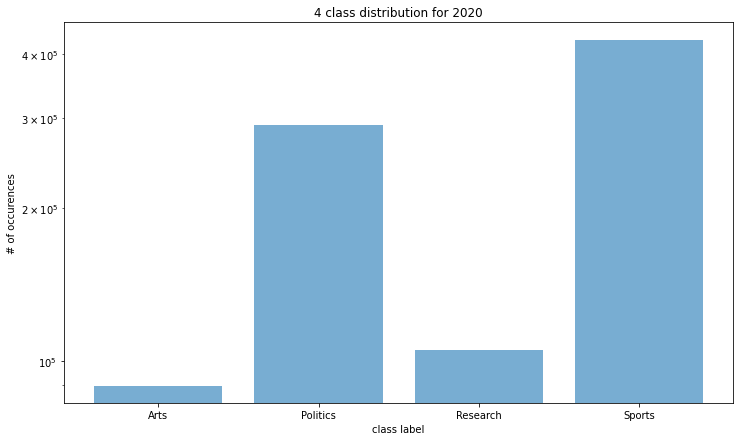

In [ ]:
plt.subplots(figsize=(12,7))
plt.bar(stats.index, stats.qids, alpha=0.6, log = True)
plt.ylabel('# of occurences')
plt.xlabel('class label')
plt.title('4 class distribution for 2020')

Everything went fine, so we may process further with merging.

In [ ]:
#Merging for 2019
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2019-filtered.csv.bz2'
filtered_2019 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2019.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter data from qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2019 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2018
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2018-filtered.csv.bz2'
filtered_2018 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2018.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2018 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2017
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2017-filtered.csv.bz2'
filtered_2017 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2017.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2017 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2016
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2016-filtered.csv.bz2'
filtered_2016 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2016.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2016 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2015
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2015-filtered.csv.bz2'
filtered_2015 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2015.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unnede columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2015 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


Now we are done with merging the data. Let's plot the distributions of clustered occupations occurencies in each year(stats_year) and for the whole data(stats_global)

In [ ]:
#creating the dataframe with all the occupations and qids counter
#for all the years
stats_global = pd.DataFrame(columns=['class_label', 'qids'])
stats_global['class_label'] = occ_classes.class_label.unique()
stats_global['qids'] = 0
stats_global = stats_global.sort_values('class_label').reset_index(drop=True)
stats_global

,class_label,qids
0,Arts,0
1,Politics,0
2,Research,0
3,Sports,0


In [ ]:
#creating the dataframe with all the occupations and qids counter
#for each year
stats_year = pd.DataFrame(columns=['class_label', 'qids'])
stats_year['class_label'] = occ_classes.class_label.unique()
stats_year['qids'] = 0
stats_year = stats_year.sort_values('class_label').reset_index(drop=True)
stats_year

,class_label,qids
0,Arts,0
1,Politics,0
2,Research,0
3,Sports,0


Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label    qids
0        Arts   89611
1    Politics  289983
2    Research  105197
3      Sports  427269


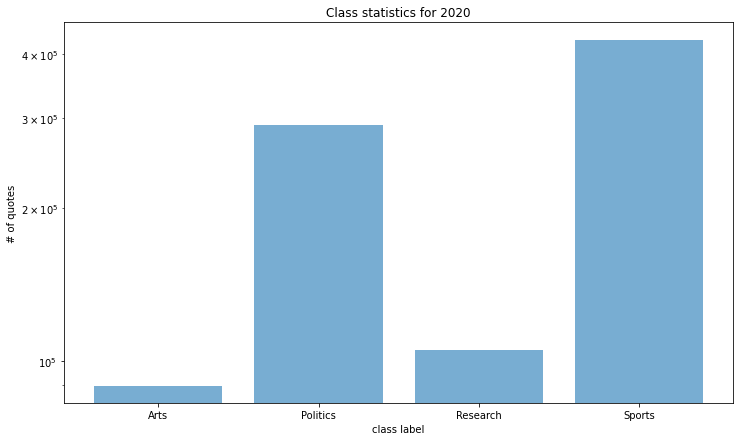

In [ ]:
#distribution for 2020
occupancy_2020 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2020.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2020, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2020')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0        Arts   386109
1    Politics  1182105
2    Research   388565
3      Sports  1991689


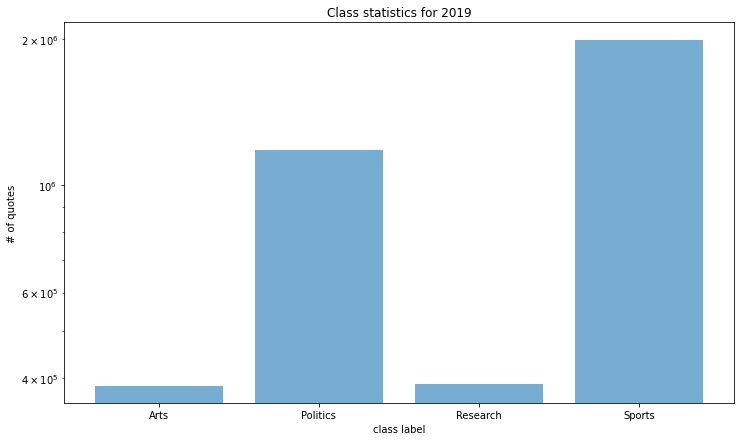

In [ ]:
#distribution for 2019
occupancy_2019 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2019.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2019, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2019')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0        Arts   872972
1    Politics  2602269
2    Research   853407
3      Sports  4575019


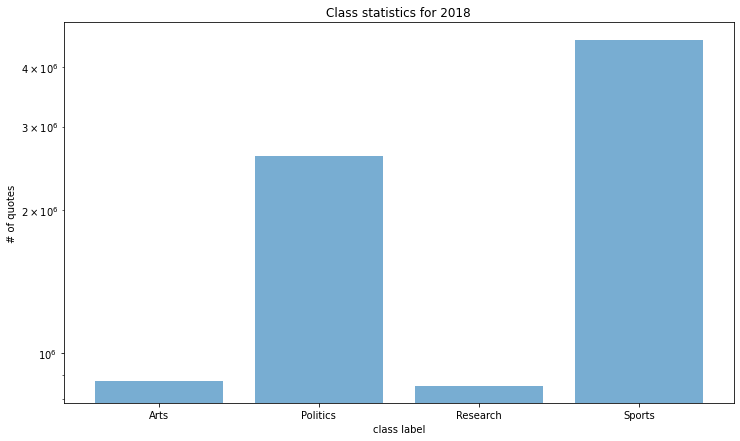

In [ ]:
#distribution for 2018
occupancy_2018 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2018.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2018, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2018')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0        Arts   468082
1    Politics  1293299
2    Research   443837
3      Sports  2671006


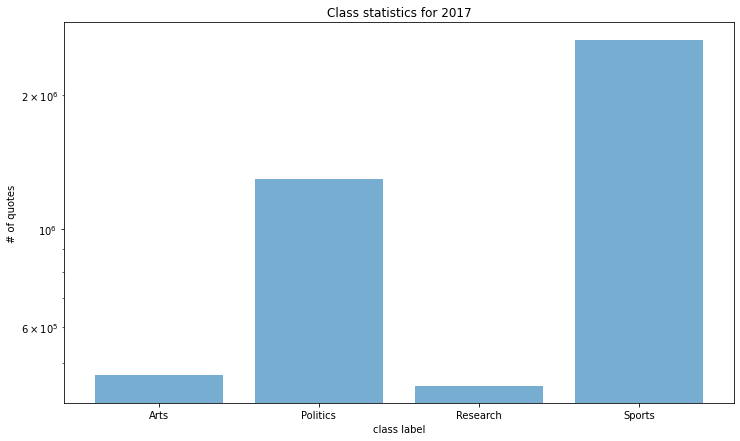

In [ ]:
#distribution for 2017
occupancy_2017 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2017.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2017, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2017')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0        Arts   245940
1    Politics   631144
2    Research   230025
3      Sports  1419138


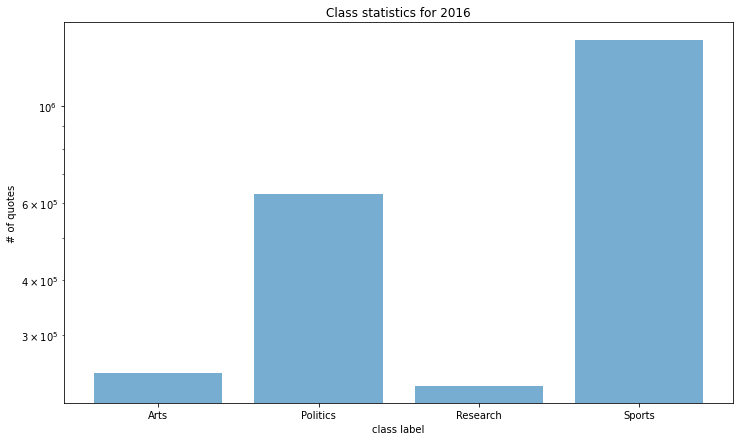

In [ ]:
#distribution for 2016
occupancy_2016 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2016.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2016, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2016')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0        Arts   359004
1    Politics   930091
2    Research   351299
3      Sports  2153340


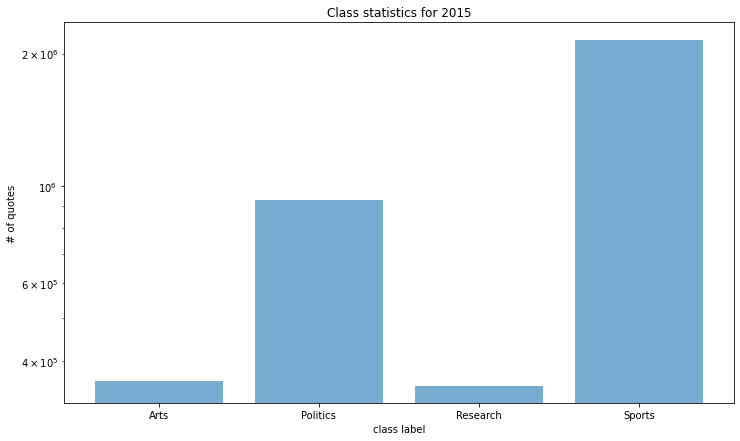

In [ ]:
#distribution for 2015
occupancy_2015 = '/content/drive/MyDrive/Merged_4/filtered_occupancy_2015.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2015, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2015')
print('--------------------------------')
print(stats_year)

  class_label      qids
0        Arts   2421718
1    Politics   6928891
2    Research   2372330
3      Sports  13237461
--------------------------------


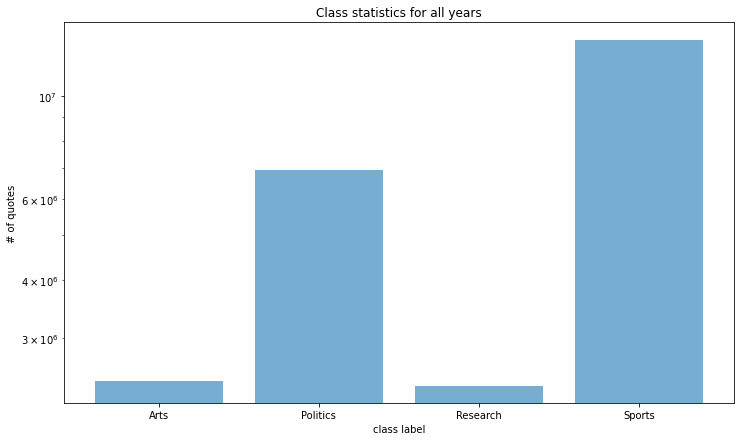

In [ ]:
#plotting the stats through all the years
plt.subplots(figsize=(12,7))
plt.bar(stats_global.class_label, stats_global.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for all years')
print(stats_global)
print('--------------------------------')

We were arguing what length of citate should we pick for further analysis and agreed on using those quotetions that have more than 50 characters, so that they may contain more specific words for occupation cluster.
Let's see the quote length distributions and the percentage of quotes with more than 50 characters in each year:

Text(0.5, 1.0, 'Quotes length distribution in 2020')

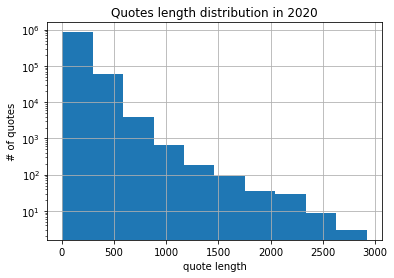

In [ ]:
#plot distribution of quotes length
check_2020 = pd.read_csv('/content/drive/MyDrive/Merged_4/filtered_occupancy_2020.csv.bz2')
check_2020['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2020')

In [ ]:
#percentage of quotes with >50 characters
check_2020[check['quotation'].str.len() > 50].shape[0] /\
check_2020.shape[0]

0.8586836392342609

In [ ]:
check_2019 = pd.read_csv('/content/drive/MyDrive/Merged_4/filtered_occupancy_2019.csv.bz2')

Text(0.5, 1.0, 'Quotes length distribution in 2019')

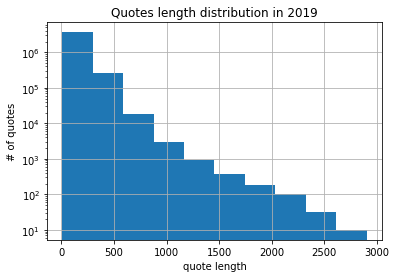

In [ ]:
#plot distribution of quotes length
check_2019['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2019')

In [ ]:
#percentage of quotes with >50 characters
check_2019[check_2019['quotation'].str.len() > 50].shape[0] /\
check_2019.shape[0]

0.8527423800826042

Text(0.5, 1.0, 'Quotes length distribution in 2016')

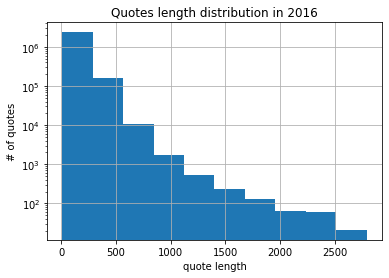

In [ ]:
#plot distribution of quotes length
check_2016 = pd.read_csv('/content/drive/MyDrive/Merged_4/filtered_occupancy_2016.csv.bz2')
check_2016['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2016')

In [ ]:
#percentage of quotes with >50 characters
check_2016[check_2016['quotation'].str.len() > 50].shape[0] /\
check_2016.shape[0]

0.8319871334829888

In [ ]:
#memory cleaning
import gc
check_2019=pd.DataFrame()
check_2016=pd.DataFrame()
del [[check_2019,check_2016]]
gc.collect()

5039

Text(0.5, 1.0, 'Quotes length distribution in 2015')

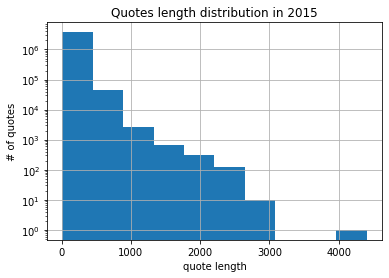

In [ ]:
#plot distribution of quotes length
check_2015 = pd.read_csv('/content/drive/MyDrive/Merged_4/filtered_occupancy_2015.csv.bz2')
check_2015['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2015')

In [ ]:
#percentage of quotes with >50 characters
check_2015[check_2015['quotation'].str.len() > 50].shape[0] /\
check_2015.shape[0]

0.8308827134427453

In [ ]:
#memory cleaning
check_2015=pd.DataFrame()
del [[check_2015]]
gc.collect()

2780

Text(0.5, 1.0, 'Quotes length distribution in 2017')

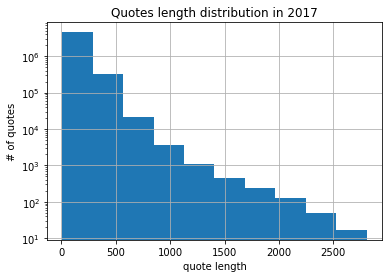

In [ ]:
#plot distribution of quotes length
check_2017 = pd.read_csv('/content/drive/MyDrive/Merged_4/filtered_occupancy_2017.csv.bz2')
check_2017['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2017')

In [ ]:
#percentage of quotes with >50 characters
check_2017[check_2017['quotation'].str.len() > 50].shape[0] /\
check_2017.shape[0]

0.8373210500584058

In [ ]:
#memory cleaning
check_2017=pd.DataFrame()
del [[check_2017]]
gc.collect()

3164

Text(0.5, 1.0, 'Quotes length distribution in 2018')

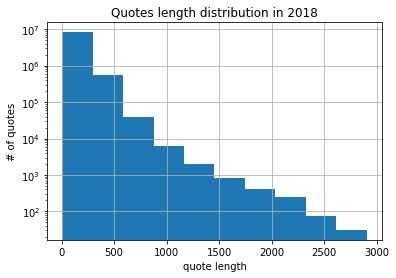

In [ ]:
#plot distribution of quotes length
check_2018 = pd.read_csv('/content/drive/MyDrive/Merged_4/filtered_occupancy_2018.csv.bz2')
check_2018['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2018')

In [ ]:
#percentage of quotes with >50 characters
check_2018[check_2018['quotation'].str.len() > 50].shape[0] /\
check_2018.shape[0]

0.8484371663944754

In [ ]:
#memory cleaning
check_2018 = pd.DataFrame()
del [[check_2018]]
gc.collect()

5453

After this analysis we may see that it's fine to take quotations containing more than fifty characters as they represent approximately 84% of the data.

Next, the merged datasets were provide to my colleague Konstantin for the model training

# Merge additional clusters to the original data(20 clusters) + Distributions:

Next we decided to check how our model will behave on 20 clusters of occupations.
The work on this step will be maid with cluters provided by my colleague, Mohamed, who did all the clustering work.

First, we read the data from clustered occupations dataset:

In [ ]:
#Read data from additional dataset clustered for 20 classes
occ_classes = pd.read_pickle(PATH+"final_output_copy_clustered.zip")
occ_classes

,occupation,id,label,classe,classe_label
index,,,,,
4,painter,Q297,Diego Velázquez,3.0,AAVTC
19,politician,Q1149,Indira Gandhi,7.0,GPA
29,politician,Q1416,Otho,7.0,GPA
32,sovereign,Q1526,Ramesses I,7.0,GPA
33,sports official,Q1638,Primo Nebiolo,NaN,NaN
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,7.0,GPA
6073733,politician,Q106406557,Andrew F. Healy,7.0,GPA
6073734,politician,Q106406560,Barker B. Howard,7.0,GPA


Second, we do some cleaning:

In [ ]:
#change class column
occ_classes.rename(columns={"classe": "class"}, inplace = True)
occ_classes

,occupation,id,label,class,classe_label
index,,,,,
4,painter,Q297,Diego Velázquez,3.0,AAVTC
19,politician,Q1149,Indira Gandhi,7.0,GPA
29,politician,Q1416,Otho,7.0,GPA
32,sovereign,Q1526,Ramesses I,7.0,GPA
33,sports official,Q1638,Primo Nebiolo,NaN,NaN
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,7.0,GPA
6073733,politician,Q106406557,Andrew F. Healy,7.0,GPA
6073734,politician,Q106406560,Barker B. Howard,7.0,GPA


Here we create a class "other" with not clustered occupations

In [ ]:
#filling nan values in class column to be 0 class
occ_classes['class'] = occ_classes['class'].fillna(0)
occ_classes

,occupation,id,label,class,classe_label
index,,,,,
4,painter,Q297,Diego Velázquez,3.0,AAVTC
19,politician,Q1149,Indira Gandhi,7.0,GPA
29,politician,Q1416,Otho,7.0,GPA
32,sovereign,Q1526,Ramesses I,7.0,GPA
33,sports official,Q1638,Primo Nebiolo,0.0,NaN
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,7.0,GPA
6073733,politician,Q106406557,Andrew F. Healy,7.0,GPA
6073734,politician,Q106406560,Barker B. Howard,7.0,GPA


In [ ]:
#filling nan values in class_label column to be "Other" class
occ_classes['classe_label'] = occ_classes['classe_label'].fillna('Other')
occ_classes

,occupation,id,label,class,classe_label
index,,,,,
4,painter,Q297,Diego Velázquez,3.0,AAVTC
19,politician,Q1149,Indira Gandhi,7.0,GPA
29,politician,Q1416,Otho,7.0,GPA
32,sovereign,Q1526,Ramesses I,7.0,GPA
33,sports official,Q1638,Primo Nebiolo,0.0,Other
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,7.0,GPA
6073733,politician,Q106406557,Andrew F. Healy,7.0,GPA
6073734,politician,Q106406560,Barker B. Howard,7.0,GPA


In [ ]:
#some sanity code
occ_classes.rename(columns={"classe_label": "class_label"}, inplace = True)

In [ ]:
#some sanity code
occ_classes['class'] = occ_classes['class'].astype("int")
occ_classes 

,occupation,id,label,class,class_label
index,,,,,
4,painter,Q297,Diego Velázquez,3,AAVTC
19,politician,Q1149,Indira Gandhi,7,GPA
29,politician,Q1416,Otho,7,GPA
32,sovereign,Q1526,Ramesses I,7,GPA
33,sports official,Q1638,Primo Nebiolo,0,Other
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,7,GPA
6073733,politician,Q106406557,Andrew F. Healy,7,GPA
6073734,politician,Q106406560,Barker B. Howard,7,GPA


Here we change 'id' to 'qids' columns for easier merging with original dataset

In [ ]:
occ_classes.rename(columns={'id':'qids'}, inplace=True)

In [ ]:
#drop lable column as it will be presented in original data
occ_classes = occ_classes.drop(columns = 'label')
occ_classes

,occupation,qids,class,class_label
index,,,,
4,painter,Q297,3,AAVTC
19,politician,Q1149,7,GPA
29,politician,Q1416,7,GPA
32,sovereign,Q1526,7,GPA
33,sports official,Q1638,0,Other
...,...,...,...,...
6073732,politician,Q106406546,7,GPA
6073733,politician,Q106406557,7,GPA
6073734,politician,Q106406560,7,GPA


Merging clustered occupations with original quotes:

In [ ]:
#function to prepare qids column in original dataset to be properly merged
#deleting unnecessary characters from it
def exclude(x):
  for excl in ['[\'', '\']']:
    x = x.replace(excl, '')
  return x

In [ ]:
#Merging for 2020
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2020-filtered.csv.bz2'
filtered_2020 = '/content/drive/MyDrive/Merged/filtered_occupancy_2020.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')
    
    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2020 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False

    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2019
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2019-filtered.csv.bz2'
filtered_2019 = '/content/drive/MyDrive/Merged/filtered_occupancy_2019.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter data from qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2019 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2018
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2018-filtered.csv.bz2'
filtered_2018 = '/content/drive/MyDrive/Merged/filtered_occupancy_2018.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2018 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2017
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2017-filtered.csv.bz2'
filtered_2017 = '/content/drive/MyDrive/Merged/filtered_occupancy_2017.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2017 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2016
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2016-filtered.csv.bz2'
filtered_2016 = '/content/drive/MyDrive/Merged/filtered_occupancy_2016.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2016 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2015
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2015-filtered.csv.bz2'
filtered_2015 = '/content/drive/MyDrive/Merged/filtered_occupancy_2015.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unnede columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2015 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


Now let's see the distributions between occupancy clustered in each year(stats_year) and for the whole years(stats_global):

In [ ]:
#creating the dataframe with all the occupations and qids counter
#for each year
stats_year = pd.DataFrame(columns=['class_label', 'qids'])
stats_year['class_label'] = occ_classes.class_label.unique()
stats_year['qids'] = 0
stats_year = stats_year.sort_values('class_label').reset_index(drop=True)
stats_year

,class_label,qids
0,AAVTC,0
1,AFNR,0
2,AS,0
3,AT,0
4,BMA,0
5,ET,0
6,F,0
7,GPA,0
8,HS,0
9,HumS,0


In [ ]:
#creating the dataframe with all the occupations and qids counter
#for all the years
stats_global = pd.DataFrame(columns=['class_label', 'qids'])
stats_global['class_label'] = occ_classes.class_label.unique()
stats_global['qids'] = 0
stats_global = stats_global.sort_values('class_label').reset_index(drop=True)
stats_global

,class_label,qids
0,AAVTC,0
1,AFNR,0
2,AS,0
3,AT,0
4,BMA,0
5,ET,0
6,F,0
7,GPA,0
8,HS,0
9,HumS,0


Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
   class_label    qids
0        AAVTC   97948
1         AFNR     348
2           AS     832
3           AT    6187
4          BMA   36087
5           ET  450557
6            F   12846
7          GPA  272315
8           HS    1990
9         HumS    4498
10          IT     433
11           J   35063
12       LPSCS   24669
13           M    4504
14         MSS    3558
15          MW    6230
16       NoOcc     228
17       Other   82675
18           R    6703
19        STEM   92454


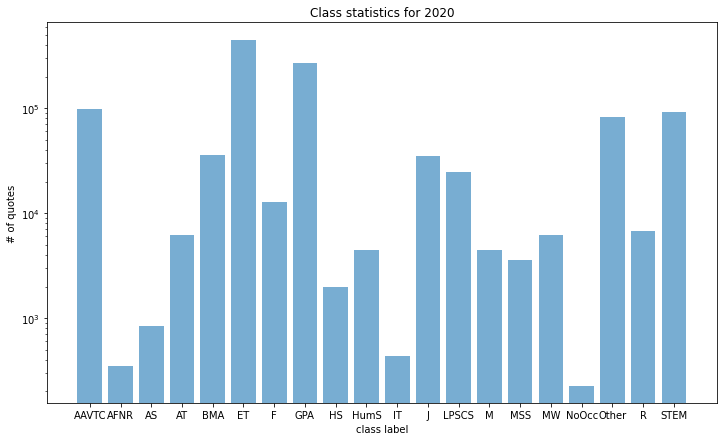

In [ ]:
#distribution for 2020
occupancy_2020 = '/content/drive/MyDrive/Merged/filtered_occupancy_2020.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2020, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2020')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
   class_label     qids
0        AAVTC   419797
1         AFNR     1617
2           AS     3601
3           AT    27297
4          BMA   153294
5           ET  2109032
6            F    44287
7          GPA  1102228
8           HS     6170
9         HumS    17098
10          IT     2206
11           J   137366
12       LPSCS   112823
13           M    19003
14         MSS    15200
15          MW    26531
16       NoOcc      145
17       Other   330053
18           R    27354
19        STEM   350355


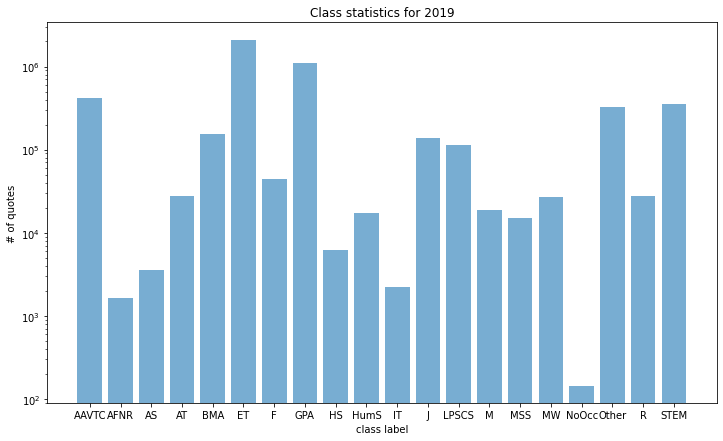

In [ ]:
#distribution for 2019
occupancy_2019 = '/content/drive/MyDrive/Merged/filtered_occupancy_2019.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2019, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2019')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
   class_label     qids
0        AAVTC   948687
1         AFNR     328

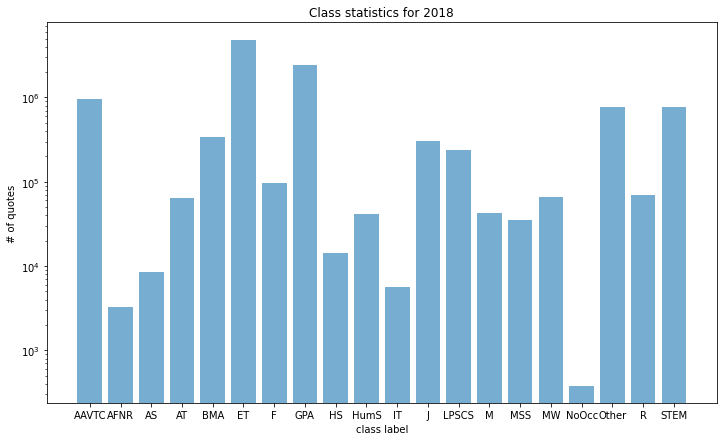

In [ ]:
#distribution for 2018
occupancy_2018 = '/content/drive/MyDrive/Merged/filtered_occupancy_2018.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2018, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2018')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
   class_label     qids
0        AAVTC   515293
1         AFNR     2205
2           AS     5130
3           AT    34662
4          BMA   180037
5           ET  2818034
6            F    49437
7          GPA  1219258
8           HS    10989
9         HumS    21383
10          IT     2478
11           J   157172
12       LPSCS   112277
13           M    27095
14         MSS    19205
15          MW    38309
16       NoOcc      286
17       Other   424916
18  

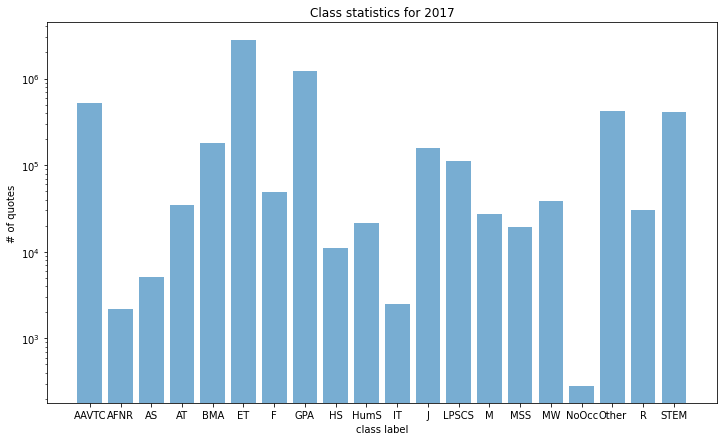

In [ ]:
#distribution for 2017
occupancy_2017 = '/content/drive/MyDrive/Merged/filtered_occupancy_2017.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2017, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2017')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
   class_label     qids
0        AAVTC   266285
1         AFNR     1015
2           AS     2766
3           AT    18394
4          BMA    97826
5           ET  1506133
6            F    26533
7          GPA   590417
8           HS     4924
9         HumS    10794
10          IT     1316
11           J    80520
12       LPSCS    59611
13           M    15268
14         MSS    10439
15          MW    17442
16       NoOcc       91
17       Other   230385
18           R    15549
19        STEM   210787


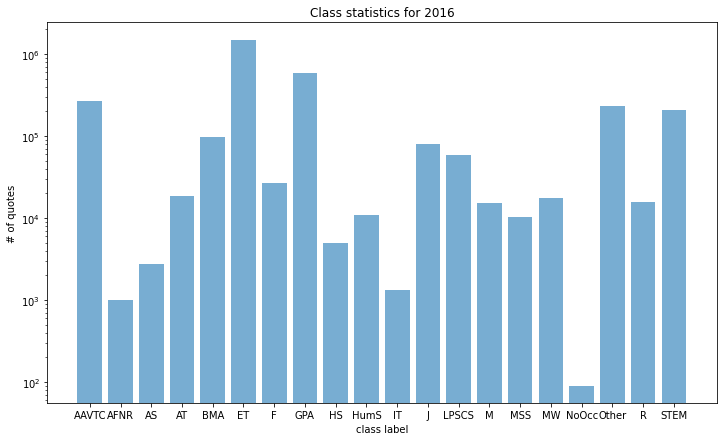

In [ ]:
#distribution for 2016
occupancy_2016 = '/content/drive/MyDrive/Merged/filtered_occupancy_2016.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2016, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2016')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
   class_label     qids
0        AAVTC   401267
1         AFNR     1425
2           AS     4106
3           AT    27353
4          BMA   155106
5           ET  2265539
6            F    44598
7          GPA   873809
8           HS     7533
9         HumS    16467
10          IT     2343
11           J   124734
12       LPSCS    89276
13           M    20414
14         MSS    13763
15          MW    25400
16       NoOcc      232
17       Other   338561
18           R    25113
19        STEM   319509


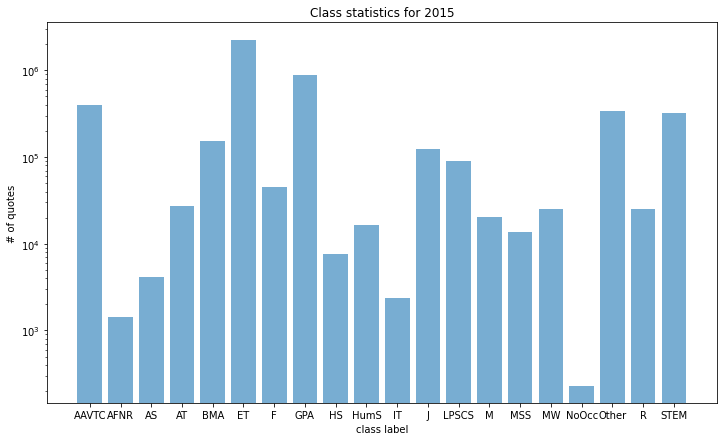

In [ ]:
#distribution for 2015
occupancy_2015 = '/content/drive/MyDrive/Merged/filtered_occupancy_2015.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2015, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2015')
print('--------------------------------')
print(stats_year)

   class_label      qids
0        AAVTC   2649277
1         AFNR      9891
2           AS     24947
3           AT    177524
4          BMA    961273
5           ET  14009216
6            F    275615
7          GPA   6491038
8           HS     46010
9         HumS    111482
10          IT     14356
11           J    839391
12       LPSCS    639833
13           M    129037
14         MSS     97653
15          MW    179833
16       NoOcc      1365
17       Other   2167753
18           R    173688
19        STEM   2152432
--------------------------------


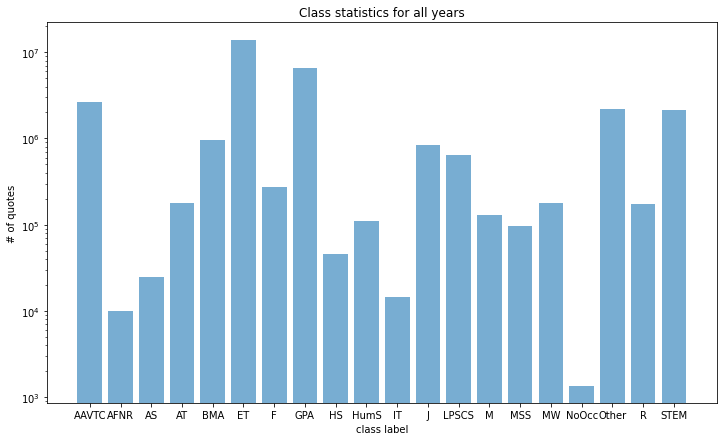

In [ ]:
#plotting the stats through all the years
plt.subplots(figsize=(12,7))
plt.bar(stats_global.class_label, stats_global.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for all years')
print(stats_global)
print('--------------------------------')

As on the previous step(4 clusters), let's see the quote length distributions and the percentage of quotes with more than 50 characters in each year:

Text(0.5, 1.0, 'Quotes length distribution in 2020')

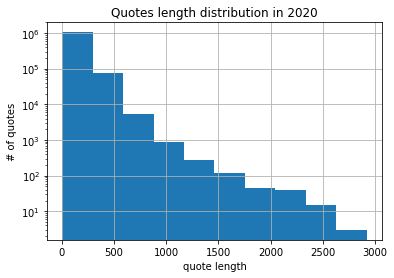

In [ ]:
#plot distribution of quotes length for 2020
check_2020 = pd.read_csv('/content/drive/MyDrive/Merged/filtered_occupancy_2020.csv.bz2')
check_2020['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2020')

In [ ]:
#percentage of quotes with >50 characters
check_2020[check_2020['quotation'].str.len() > 50].shape[0] /\
check_2020.shape[0]

0.8568534151957022

Text(0.5, 1.0, 'Quotes length distribution in 2019')

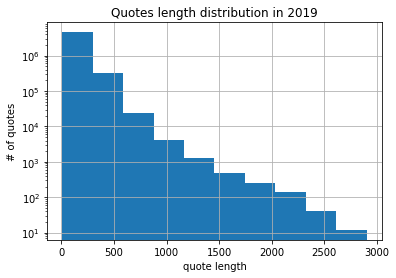

In [ ]:
#plot distribution of quotes length for 2019
check_2019 = pd.read_csv('/content/drive/MyDrive/Merged/filtered_occupancy_2019.csv.bz2')
check_2019['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2019')

In [ ]:
#percentage of quotes with >50 characters
check_2019[check_2019['quotation'].str.len() > 50].shape[0] /\
check_2019.shape[0]

0.8512053005459023

Text(0.5, 1.0, 'Quotes length distribution in 2016')

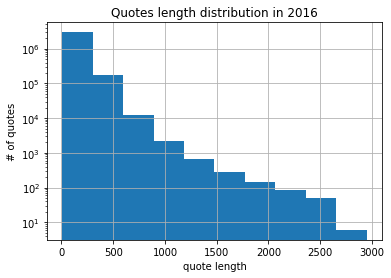

In [ ]:
#plot distribution of quotes length for 2016
check_2016 = pd.read_csv('/content/drive/MyDrive/Merged/filtered_occupancy_2016.csv.bz2')
check_2016['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2016')

In [ ]:
#percentage of quotes with >50 characters
check_2016[check_2016['quotation'].str.len() > 50].shape[0] /\
check_2016.shape[0]

0.8315907651835863

In [ ]:
#memory cleaning
check_2020 = pd.DataFrame()
check_2019 = pd.DataFrame()
check_2016 = pd.DataFrame()
del [[check_2019, check_2016, check_2020]]
gc.collect()

4585

Text(0.5, 1.0, 'Quotes length distribution in 2015')

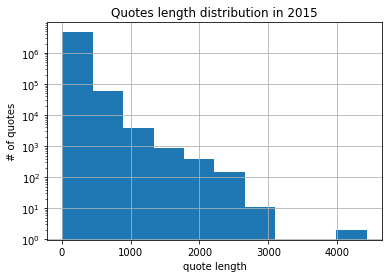

In [ ]:
#plot distribution of quotes length for 2015
check_2015 = pd.read_csv('/content/drive/MyDrive/Merged/filtered_occupancy_2015.csv.bz2')
check_2015['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2015')

In [ ]:
#percentage of quotes with >50 characters
check_2015[check_2015['quotation'].str.len() > 50].shape[0] /\
check_2015.shape[0]

0.8309103576795609

In [ ]:
#memory cleaning
check_2015 = pd.DataFrame()
del [[check_2015]]
gc.collect()

25834

Text(0.5, 1.0, 'Quotes length distribution in 2017')

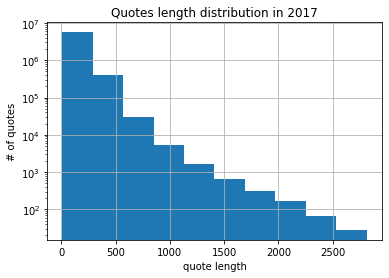

In [ ]:
#plot distribution of quotes length for 2017
check_2017 = pd.read_csv('/content/drive/MyDrive/Merged/filtered_occupancy_2017.csv.bz2')
check_2017['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2017')

In [ ]:
#percentage of quotes with >50 characters
check_2017[check_2017['quotation'].str.len() > 50].shape[0] /\
check_2017.shape[0]

0.8366569193542571

In [ ]:
#memory cleaning
check_2017 = pd.DataFrame()
del [[check_2017]]
gc.collect()

3183

Text(0.5, 1.0, 'Quotes length distribution in 2018')

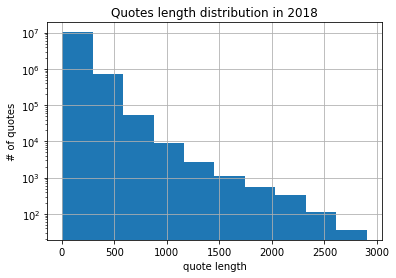

In [ ]:
#plot distribution of quotes length for 2018
check_2018 = pd.read_csv('/content/drive/MyDrive/Merged/filtered_occupancy_2018.csv.bz2')
check_2018['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2018')

In [ ]:
#percentage of quotes with >50 characters
check_2018[check_2018['quotation'].str.len() > 50].shape[0] /\
check_2018.shape[0]

0.8469397105708452

In [ ]:
#memory cleaning
check_2018 = pd.DataFrame()
del [[check_2018]]
gc.collect()

2250

After this analysis we may see that it's fine to take quotations containing more than fifty characters as they represent approximately 84% of the data.

Further, the created csv files of merged occupation clusters and original datasets are processed to the model.

# Merge additional clusters to the original data(10 clusters) + Distributions:

After we didn't achieve any great results with 20 clusters, we decided to work with only 12 of them. However, after some analysis, which you will see later in this section, the number was reduced to 10. The clusterized occupations dataset is again provided by my colleague.

First, we read the data from clustered occupations dataset and do some sanity updates:

In [ ]:
#Read data from additional dataset clustered for 12 classes
occ_classes = pd.read_pickle(PATH+"final_output_copy_clustered_new.zip")
occ_classes

,occupation,id,label,classe,classe_label
index,,,,,
4,painter,Q297,Diego Velázquez,1.0,AAVTC
19,politician,Q1149,Indira Gandhi,3.0,GPAxLPSCS
29,politician,Q1416,Otho,3.0,GPAxLPSCS
32,sovereign,Q1526,Ramesses I,3.0,GPAxLPSCS
33,sports official,Q1638,Primo Nebiolo,NaN,NaN
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,3.0,GPAxLPSCS
6073733,politician,Q106406557,Andrew F. Healy,3.0,GPAxLPSCS
6073734,politician,Q106406560,Barker B. Howard,3.0,GPAxLPSCS


In [ ]:
#column renaming
occ_classes.rename(columns={"classe": "class"}, inplace = True)
occ_classes

,occupation,id,label,class,classe_label
index,,,,,
4,painter,Q297,Diego Velázquez,1.0,AAVTC
19,politician,Q1149,Indira Gandhi,3.0,GPAxLPSCS
29,politician,Q1416,Otho,3.0,GPAxLPSCS
32,sovereign,Q1526,Ramesses I,3.0,GPAxLPSCS
33,sports official,Q1638,Primo Nebiolo,NaN,NaN
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,3.0,GPAxLPSCS
6073733,politician,Q106406557,Andrew F. Healy,3.0,GPAxLPSCS
6073734,politician,Q106406560,Barker B. Howard,3.0,GPAxLPSCS


In [ ]:
#dropping nan values
occ_classes = occ_classes.dropna()
occ_classes

,occupation,id,label,class,classe_label
index,,,,,
4,painter,Q297,Diego Velázquez,1.0,AAVTC
19,politician,Q1149,Indira Gandhi,3.0,GPAxLPSCS
29,politician,Q1416,Otho,3.0,GPAxLPSCS
32,sovereign,Q1526,Ramesses I,3.0,GPAxLPSCS
37,athletics competitor,Q1738,Robert Grabarz,6.0,SPORTS
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,3.0,GPAxLPSCS
6073733,politician,Q106406557,Andrew F. Healy,3.0,GPAxLPSCS
6073734,politician,Q106406560,Barker B. Howard,3.0,GPAxLPSCS


In [ ]:
#column renaming
occ_classes.rename(columns={"classe_label": "class_label"}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#column casting to int
occ_classes['class'] = occ_classes['class'].astype("int")
occ_classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,occupation,id,label,class,class_label
index,,,,,
4,painter,Q297,Diego Velázquez,1,AAVTC
19,politician,Q1149,Indira Gandhi,3,GPAxLPSCS
29,politician,Q1416,Otho,3,GPAxLPSCS
32,sovereign,Q1526,Ramesses I,3,GPAxLPSCS
37,athletics competitor,Q1738,Robert Grabarz,6,SPORTS
...,...,...,...,...,...
6073732,politician,Q106406546,Leonard T. Gaskill,3,GPAxLPSCS
6073733,politician,Q106406557,Andrew F. Healy,3,GPAxLPSCS
6073734,politician,Q106406560,Barker B. Howard,3,GPAxLPSCS


In [ ]:
#column renaming
occ_classes.rename(columns={'id':'qids'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#drop unnecessary column label
occ_classes = occ_classes.drop(columns = 'label')
occ_classes

,occupation,qids,class,class_label
index,,,,
4,painter,Q297,1,AAVTC
19,politician,Q1149,3,GPAxLPSCS
29,politician,Q1416,3,GPAxLPSCS
32,sovereign,Q1526,3,GPAxLPSCS
37,athletics competitor,Q1738,6,SPORTS
...,...,...,...,...
6073732,politician,Q106406546,3,GPAxLPSCS
6073733,politician,Q106406557,3,GPAxLPSCS
6073734,politician,Q106406560,3,GPAxLPSCS


Now we are ready for merging.

In [ ]:
#function to prepare qids column in original dataset to be properly merged
#deleting unnecessary characters from it
def exclude(x):
  for excl in ['[\'', '\']']:
    x = x.replace(excl, '')
  return x

In [ ]:
#Merging for 2020
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2020-filtered.csv.bz2'
filtered_2020 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2020.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')
    
    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2020 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False

    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


Let's check the correctness of merging.

In [ ]:
#read data
check = pd.read_csv('/content/drive/MyDrive/Merged_10/filtered_occupancy_2020.csv.bz2')
check.head(5)

,quoteID,quotation,speaker,qids,date,probas,occupation,class,class_label
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,2020-01-16 12:00:13,"[['Sue Myrick', '0.8867'], ['None', '0.0992'],...",politician,3,GPAxLPSCS
1,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,Q5268447,2020-01-17 13:03:00,"[['Dexter Smith', '0.924'], ['None', '0.076']]",cricketer,6,SPORTS
2,2020-03-12-000358,1. FM is entitled to go straight to press conf...,Paul Masterton,Q30164281,2020-03-12 19:15:29,"[['Paul Masterton', '0.8082'], ['None', '0.144...",politician,3,GPAxLPSCS
3,2020-01-08-000594,"11 straight weeks of pre-season,",Aphelele Fassi,Q56255401,2020-01-08 10:22:11,"[['Aphelele Fassi', '0.9033'], ['None', '0.096...",rugby union player,6,SPORTS
4,2020-02-11-076740,That has given us other options and made him a...,Aphelele Fassi,Q56255401,2020-02-11 16:02:38,"[['Aphelele Fassi', '0.7389'], ['None', '0.224...",rugby union player,6,SPORTS


In [ ]:
#get number of rows
check.shape[0]

1057940

In [ ]:
#get distribution along clusters
stats = pd.DataFrame(check.groupby(['class_label'])['qids'].count())
stats.index

Index(['AAVTC', 'ATE', 'BMAxF', 'GPAxLPSCS', 'HS', 'J', 'M', 'MSSxHumS', 'MW',
       'R', 'SPORTS', 'STEMxIT'],
      dtype='object', name='class_label')

Text(0.5, 1.0, 'Distribution for 12 clusters')

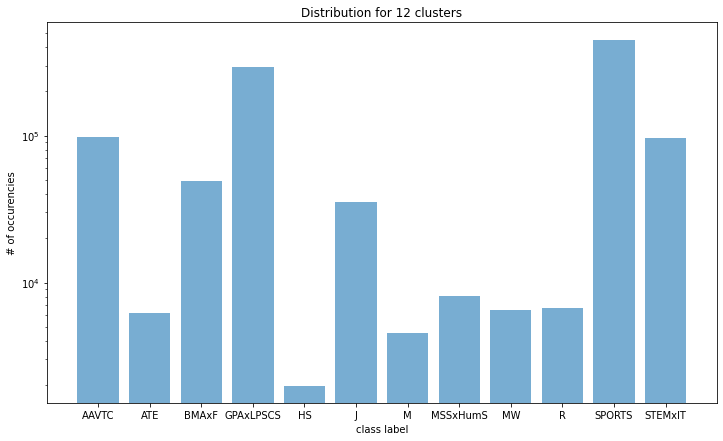

In [ ]:
#plot distribution
plt.subplots(figsize=(12,7))
plt.bar(stats.index, stats.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of occurencies')
plt.title('Distribution for 12 clusters')

We may see that there's very little amount of data in some of the clusters: ATE, MW, R, HS, M, MSSxHumS

In [ ]:
labels = ['ATE', 'HS', 'M', 'MSSxHumS', 'MW', 'R']
for x in labels:
  print('for class ', x,':')
  print(check[check['class_label'] == x].shape[0]/check.shape[0])

for class  ATE :
0.005848157740514585
for class  HS :
0.001881014046165189
for class  M :
0.00425733028338091
for class  MSSxHumS :
0.007614798570807419
for class  MW :
0.006117549199387489
for class  R :
0.006335898066052895


Setting the threshold as 0.5% we may say that HS and M have to less quotes, so we decided to merge them with appropriate clusters. M(manufactoring) will go to AAVTC(arts) and HS(health science) to STEM(sciences).

In [ ]:
#changing class_label for M
occ_classes.loc[occ_classes['class_label'] == 'M', 'class_label'] = 'AAVTC'
occ_classes.class_label.unique()

array(['AAVTC', 'GPAxLPSCS', 'SPORTS', 'MW', 'STEMxIT', 'R', 'BMAxF', 'J',
       'ATE', 'MSSxHumS', 'HS'], dtype=object)

In [ ]:
#changing class_label for HS
occ_classes.loc[occ_classes['class_label'] == 'HS', 'class_label'] = 'STEMxIT'
occ_classes.class_label.unique()

array(['AAVTC', 'GPAxLPSCS', 'SPORTS', 'MW', 'STEMxIT', 'R', 'BMAxF', 'J',
       'ATE', 'MSSxHumS'], dtype=object)

In [ ]:
#changing class for M
occ_classes.loc[occ_classes['class'] == 12, 'class'] = 1
occ_classes['class'].unique()

array([ 1,  3,  6, 11,  7,  9,  2, 10,  5,  4,  8])

In [ ]:
#changing class for HS
occ_classes.loc[occ_classes['class'] == 8, 'class'] = 7
occ_classes['class'].unique()

array([ 1,  3,  6, 11,  7,  9,  2, 10,  5,  4])

In [45]:
#Changing the 11th class with the currently empty 8th
occ_classes.loc[occ_classes['class'] == 11, 'class'] = 8
occ_classes['class'].unique()

array([ 1,  3,  6,  8,  7,  9,  2, 10,  5,  4])

In [ ]:
occ_classes[['class', 'class_label']].groupby(['class','class_label']).count()

,
class,class_label
1,AAVTC
2,BMAxF
3,GPAxLPSCS
4,MSSxHumS
5,ATE
6,SPORTS
7,STEMxIT
8,MW
9,R


In [44]:
#Merging for 2020
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2020-filtered.csv.bz2'
filtered_2020 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2020.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')
    
    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2020 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False

    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2019
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2019-filtered.csv.bz2'
filtered_2019 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2019.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter data from qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2019 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2018
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2018-filtered.csv.bz2'
filtered_2018 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2018.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2018 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2017
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2017-filtered.csv.bz2'
filtered_2017 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2017.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2017 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2016
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2016-filtered.csv.bz2'
filtered_2016 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2016.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2016 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2015
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2015-filtered.csv.bz2'
filtered_2015 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2015.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unnede columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2015 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


Now let's see the distributions between occupancy clustered in each year(stats_year) and for the whole years(stats_global):

In [46]:
#creating the dataframe with all the occupations and qids counter
#for each year
stats_year = pd.DataFrame(columns=['class_label', 'qids'])
stats_year['class_label'] = occ_classes.class_label.unique()
stats_year['qids'] = 0
stats_year = stats_year.sort_values('class_label').reset_index(drop=True)
stats_year

,class_label,qids
0,AAVTC,0
1,ATE,0
2,BMAxF,0
3,GPAxLPSCS,0
4,J,0
5,MSSxHumS,0
6,MW,0
7,R,0
8,SPORTS,0
9,STEMxIT,0


In [47]:
#creating the dataframe with all the occupations and qids counter
#for all the years
stats_global = pd.DataFrame(columns=['class_label', 'qids'])
stats_global['class_label'] = occ_classes.class_label.unique()
stats_global['qids'] = 0
stats_global = stats_global.sort_values('class_label').reset_index(drop=True)
stats_global

,class_label,qids
0,AAVTC,0
1,ATE,0
2,BMAxF,0
3,GPAxLPSCS,0
4,J,0
5,MSSxHumS,0
6,MW,0
7,R,0
8,SPORTS,0
9,STEMxIT,0


Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label    qids
0       AAVTC  102452
1         ATE    6187
2       BMAxF   48933
3   GPAxLPSCS  294552
4           J   35063
5    MSSxHumS    8056
6          MW    6472
7           R    6703
8      SPORTS  450557
9     STEMxIT   98965


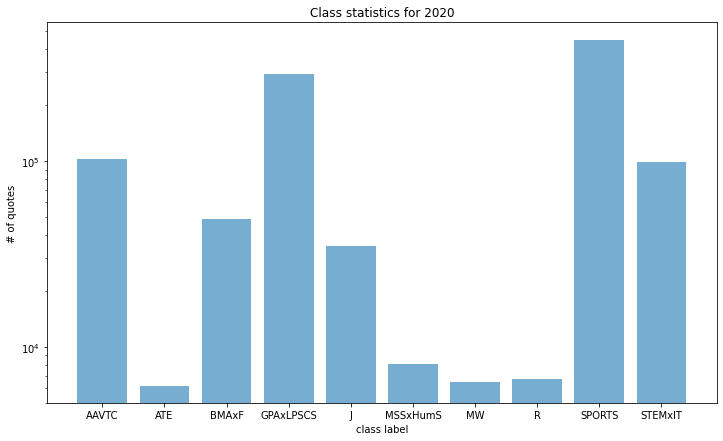

In [48]:
#distribution for 2020
occupancy_2020 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2020.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2020, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2020')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0       AAVTC   438800
1         ATE    27297
2       BMAxF   197581
3   GPAxLPSCS  1205386
4           J   137366
5    MSSxHumS    32298
6          MW    27871
7           R    27354
8      SPORTS  2109032
9     STEMxIT   375497


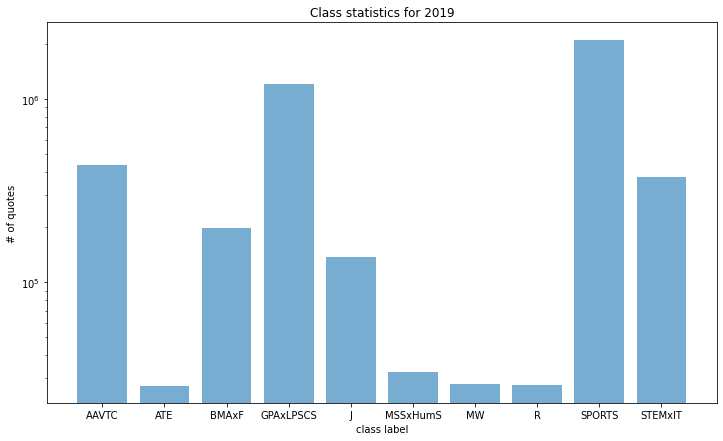

In [49]:
#distribution for 2019
occupancy_2019 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2019.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2019, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2019')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0       AAVTC   991440
1         ATE    63631
2       BMAxF   436837
3   GPAxLPSCS  2653241
4           J   304536
5    MSSxH

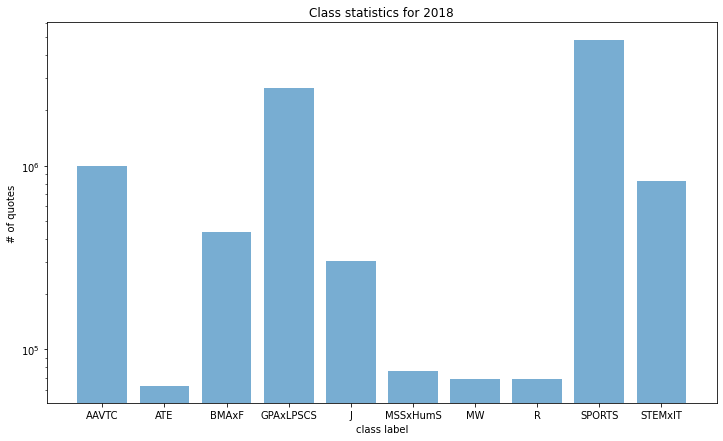

In [51]:
#distribution for 2018
occupancy_2018 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2018.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2018, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2018')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0       AAVTC   542388
1         ATE    34662
2       BMAxF   229474
3   GPAxLPSCS  1320206
4           J   157172
5    MSSxHumS    40588
6          MW    40039
7           R    29972
8      SPORTS  2818034
9     STEMxIT   439719


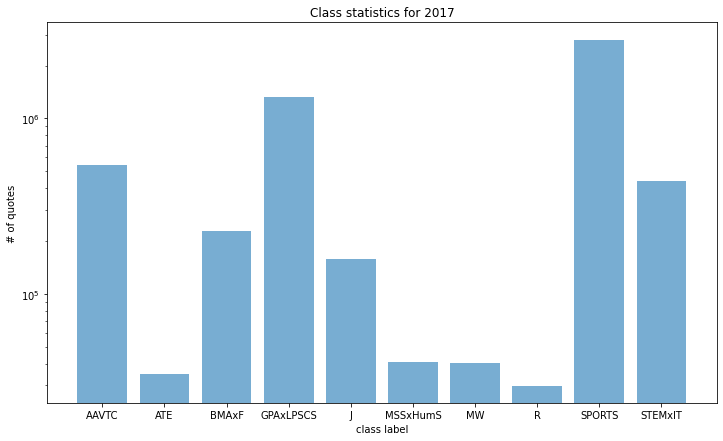

In [52]:
#distribution for 2017
occupancy_2017 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2017.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2017, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2017')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0       AAVTC   281553
1         ATE    18394
2       BMAxF   124359
3   GPAxLPSCS   643981
4           J    80520
5    MSSxHumS    21233
6          MW    18528
7           R    15549
8      SPORTS  1506133
9     STEMxIT   227741


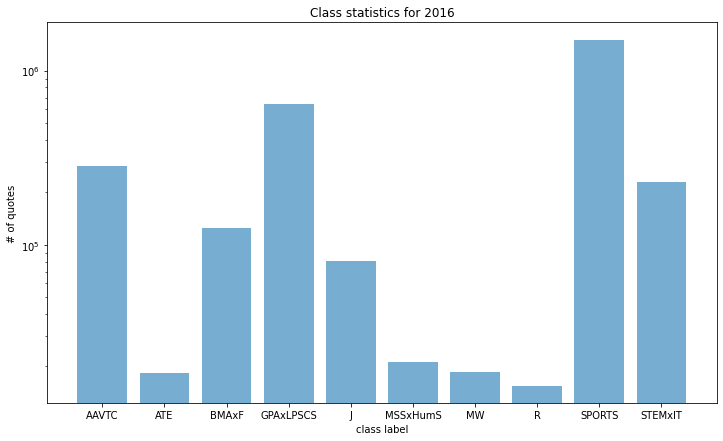

In [53]:
#distribution for 2016
occupancy_2016 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2016.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2016, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2016')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0       AAVTC   421681
1         ATE    27353
2       BMAxF   199704
3   GPAxLPSCS   954902
4           J   124734
5    MSSxHumS    30230
6          MW    26957
7           R    25113
8      SPORTS  2265539
9     STEMxIT   344822


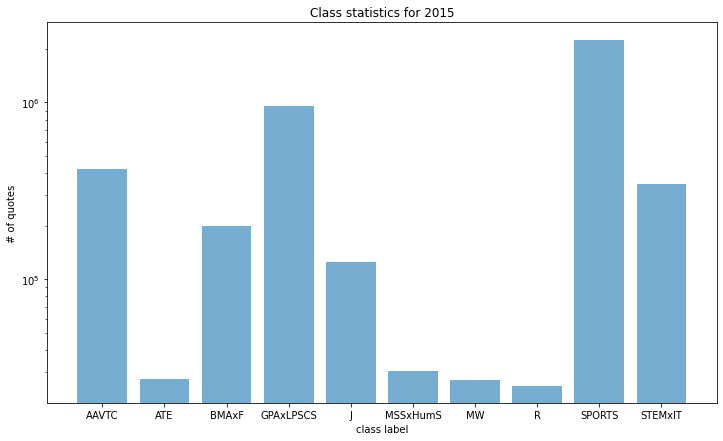

In [54]:
#distribution for 2015
occupancy_2015 = '/content/drive/MyDrive/Merged_10/filtered_occupancy_2015.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2015, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2015')
print('--------------------------------')
print(stats_year)

  class_label      qids
0       AAVTC   2778314
1         ATE    177524
2       BMAxF   1236888
3   GPAxLPSCS   7072268
4           J    839391
5    MSSxHumS    209135
6          MW    188863
7           R    173688
8      SPORTS  14009216
9     STEMxIT   2316481
--------------------------------


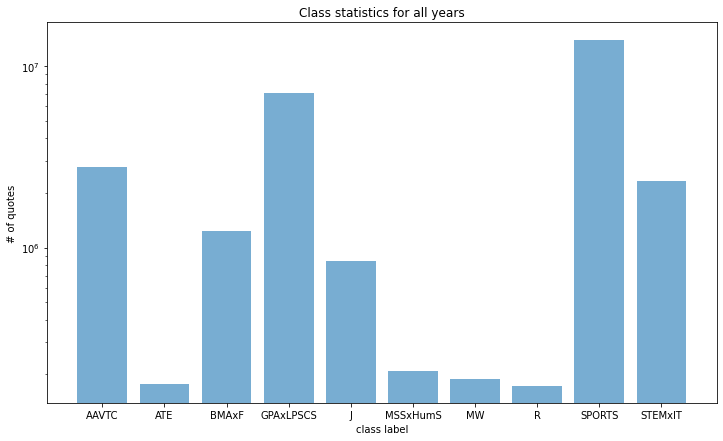

In [55]:
#plotting the stats through all the years
plt.subplots(figsize=(12,7))
plt.bar(stats_global.class_label, stats_global.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for all years')
print(stats_global)
print('--------------------------------')

As before, let's also check that we r fine with getting rid of quotes with less than 50 characters.

Text(0.5, 1.0, 'Quotes length distribution in 2020')

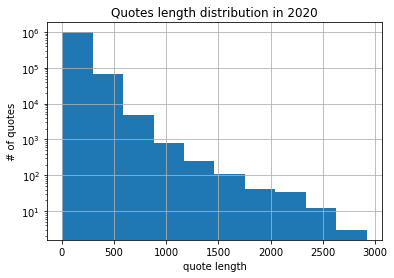

In [56]:
#plot distribution of quotes length for 2020
check_2020 = pd.read_csv('/content/drive/MyDrive/Merged_10/filtered_occupancy_2020.csv.bz2')
check_2020['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2020')

In [57]:
#percentage of quotes with >50 characters
check_2020[check_2020['quotation'].str.len() > 50].shape[0] /\
check_2020.shape[0]

0.8574531636954836

Text(0.5, 1.0, 'Quotes length distribution in 2019')

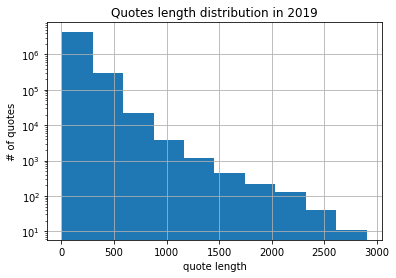

In [58]:
#plot distribution of quotes length for 2019
check_2019 = pd.read_csv('/content/drive/MyDrive/Merged_10/filtered_occupancy_2019.csv.bz2')
check_2019['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2019')

In [59]:
#percentage of quotes with >50 characters
check_2019[check_2019['quotation'].str.len() > 50].shape[0] /\
check_2019.shape[0]

0.8517395066749197

Text(0.5, 1.0, 'Quotes length distribution in 2016')

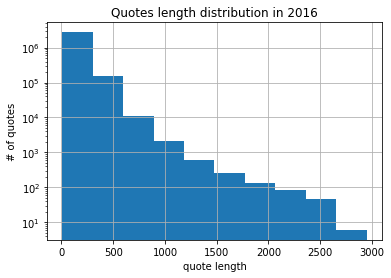

In [60]:
#plot distribution of quotes length for 2016
check_2016 = pd.read_csv('/content/drive/MyDrive/Merged_10/filtered_occupancy_2016.csv.bz2')
check_2016['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2016')

In [61]:
#percentage of quotes with >50 characters
check_2016[check_2016['quotation'].str.len() > 50].shape[0] /\
check_2016.shape[0]

0.8318589131144377

In [62]:
#memory cleaning
check_2020 = pd.DataFrame()
check_2019 = pd.DataFrame()
check_2016 = pd.DataFrame()
del [[check_2019, check_2016, check_2020]]
gc.collect()

8680

Text(0.5, 1.0, 'Quotes length distribution in 2015')

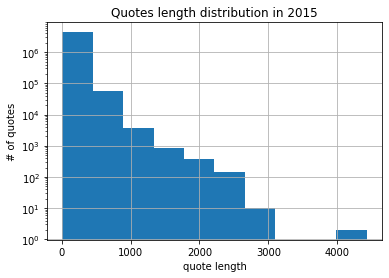

In [4]:
#plot distribution of quotes length for 2015
check_2015 = pd.read_csv('/content/drive/MyDrive/Merged_10/filtered_occupancy_2015.csv.bz2')
check_2015['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2015')

In [5]:
#percentage of quotes with >50 characters
check_2015[check_2015['quotation'].str.len() > 50].shape[0] /\
check_2015.shape[0]

0.8309119923275885

In [6]:
#memory cleaning
check_2015 = pd.DataFrame()
del [[check_2015]]
gc.collect()

5333

Text(0.5, 1.0, 'Quotes length distribution in 2017')

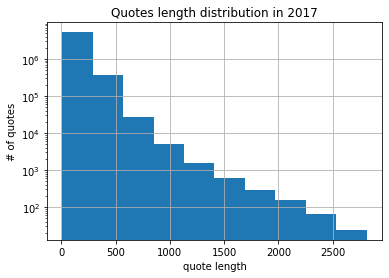

In [7]:
#plot distribution of quotes length for 2017
check_2017 = pd.read_csv('/content/drive/MyDrive/Merged_10/filtered_occupancy_2017.csv.bz2')
check_2017['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2017')

In [8]:
#percentage of quotes with >50 characters
check_2017[check_2017['quotation'].str.len() > 50].shape[0] /\
check_2017.shape[0]

0.8368613653951149

In [9]:
#memory cleaning
check_2017 = pd.DataFrame()
del [[check_2017]]
gc.collect()

3430

Text(0.5, 1.0, 'Quotes length distribution in 2018')

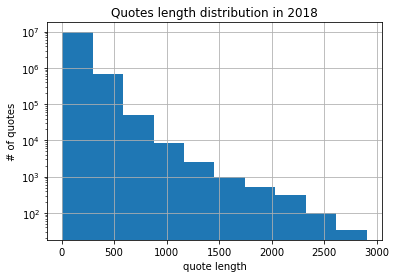

In [10]:
#plot distribution of quotes length for 2018
check_2018 = pd.read_csv('/content/drive/MyDrive/Merged_10/filtered_occupancy_2018.csv.bz2')
check_2018['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2018')

In [11]:
#percentage of quotes with >50 characters
check_2018[check_2018['quotation'].str.len() > 50].shape[0] /\
check_2018.shape[0]

0.8474287299308311

In [12]:
#memory cleaning
check_2018 = pd.DataFrame()
del [[check_2018]]
gc.collect()

3663

After this analysis we may see that it's fine to take quotations containing more than fifty characters as they represent approximately 84% of the data.

Further, the created csv files of merged occupation clusters and original datasets are processed to the model.

# 10 clusters made with ML algorithm

A day before deadline, my colleague has achieved good results of clustering the data with machine learning algorithm. So let's try to see the insights from merging it with quotes data.

First, we read the data from clustered occupations dataset:

In [ ]:
#Read data from additional dataset clustered for 20 classes
occ_classes = pd.read_pickle(PATH+"df_name_occup_clustered.zip")
occ_classes

,occupation,class_label,occupation_cluster,clustering_confidence,class,id,label
index,,,,,,,
5635908,1859,MW,military & war,78.2195,9,Q22797067,Thomas Harris
844651,3-cushion player,ST,sports & training,99.3715,5,Q3081435,Francis Forton
2799826,3-cushion player,ST,sports & training,99.3715,5,Q76885206,Nguyễn Đức Anh Chiến
4316758,3-cushion player,ST,sports & training,99.3715,5,Q77664563,Augusto Vergez
3414448,7th State Duma of the Russian Federation,GPALPSCS,government & public administration & law & pub...,77.5579,2,Q42370437,Dmitry Ionin
...,...,...,...,...,...,...,...
200772,Оrdinary professor,ATE,academic & teacher & education,99.8187,4,Q9341704,Stanisław Błaszkowiak
3718875,Оrdinary professor,ATE,academic & teacher & education,99.8187,4,Q95905011,Robert Jaretzky
4214948,Оrdinary professor,ATE,academic & teacher & education,99.8187,4,Q55683940,Joannes Evangelista Vintler


In [ ]:
occ_classes.rename(columns={'id':'qids'}, inplace=True)

In [ ]:
#drop lable column as it will be presented in original data
occ_classes = occ_classes.drop(columns = ['label', 'occupation_cluster', 'clustering_confidence'])
occ_classes

,occupation,class_label,class,qids
index,,,,
5635908,1859,MW,9,Q22797067
844651,3-cushion player,ST,5,Q3081435
2799826,3-cushion player,ST,5,Q76885206
4316758,3-cushion player,ST,5,Q77664563
3414448,7th State Duma of the Russian Federation,GPALPSCS,2,Q42370437
...,...,...,...,...
200772,Оrdinary professor,ATE,4,Q9341704
3718875,Оrdinary professor,ATE,4,Q95905011
4214948,Оrdinary professor,ATE,4,Q55683940


Merging clustered occupations with original quotes:

In [ ]:
#function to prepare qids column in original dataset to be properly merged
#deleting unnecessary characters from it
def exclude(x):
  for excl in ['[\'', '\']']:
    x = x.replace(excl, '')
  return x

In [ ]:
#Merging for 2020
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2020-filtered.csv.bz2'
filtered_2020 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2020.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')
    
    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2020 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False

    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2019
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2019-filtered.csv.bz2'
filtered_2019 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2019.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter data from qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2019 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2018
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2018-filtered.csv.bz2'
filtered_2018 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2018.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2018 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2017
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2017-filtered.csv.bz2'
filtered_2017 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2017.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2017 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2016
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2016-filtered.csv.bz2'
filtered_2016 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2016.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unneded columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2016 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


In [ ]:
#Merging for 2015
path_to_file = '/content/drive/MyDrive/QuotesFiltered/quotes-2015-filtered.csv.bz2'
filtered_2015 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2015.csv.bz2'
df_reader = pd.read_csv(path_to_file, compression='bz2', chunksize=500000)
header = True
for chunk in df_reader:
    print('processing 500000')

    #drop unnede columns
    chunk = chunk.drop(columns=['numOccurrences', 'urls', 'phase'])
    #filter qids column
    chunk['qids'] = chunk['qids'].astype("string").apply(exclude)
    #merging
    chunk.merge(occ_classes, on='qids').to_csv(filtered_2015 , index=False, \
                                               compression = 'bz2', mode='a', header=header)
    header = False
    
    print('end')

processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end
processing 500000
end


Now let's see the distributions between occupancy clustered in each year(stats_year) and for the whole years(stats_global):

In [ ]:
#creating the dataframe with all the occupations and qids counter
#for each year
stats_year = pd.DataFrame(columns=['class_label', 'qids'])
stats_year['class_label'] = occ_classes.class_label.unique()
stats_year['qids'] = 0
stats_year = stats_year.sort_values('class_label').reset_index(drop=True)
stats_year

,class_label,qids
0,AAVTCM,0
1,ATE,0
2,BMF,0
3,GPALPSCS,0
4,J,0
5,MSHS,0
6,MW,0
7,R,0
8,SEMITHS,0
9,ST,0


In [ ]:
#creating the dataframe with all the occupations and qids counter
#for all the years
stats_global = pd.DataFrame(columns=['class_label', 'qids'])
stats_global['class_label'] = occ_classes.class_label.unique()
stats_global['qids'] = 0
stats_global = stats_global.sort_values('class_label').reset_index(drop=True)
stats_global

,class_label,qids
0,AAVTCM,0
1,ATE,0
2,BMF,0
3,GPALPSCS,0
4,J,0
5,MSHS,0
6,MW,0
7,R,0
8,SEMITHS,0
9,ST,0


Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label    qids
0      AAVTCM  116204
1         ATE   15367
2         BMF   51118
3    GPALPSCS  305530
4           J   45779
5        MSHS     525
6          MW   15809
7           R   16618
8     SEMITHS  100845
9          ST  472330


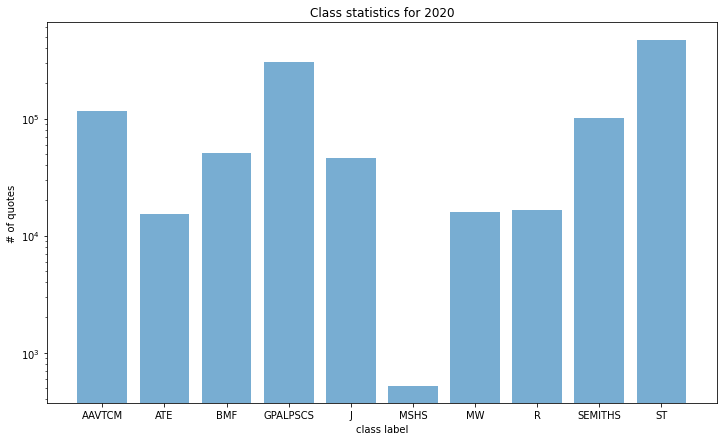

In [ ]:
#distribution for 2020
occupancy_2020 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2020.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2020, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2020')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0      AAVTCM   491720
1         ATE    67664
2         BMF   203607
3    GPALPSCS  1253002
4           J   188364
5        MSHS     2216
6          MW    63520
7           R    66950
8     SEMITHS   370438
9          ST  2197976


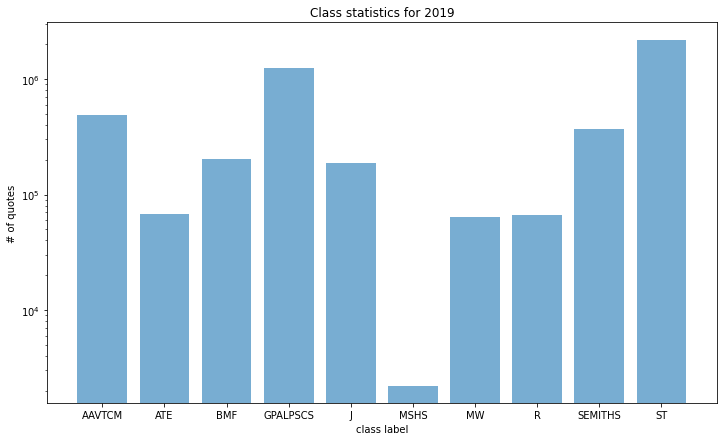

In [ ]:
#distribution for 2019
occupancy_2019 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2019.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2019, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2019')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0      AAVTCM  1104051
1         ATE   155954
2

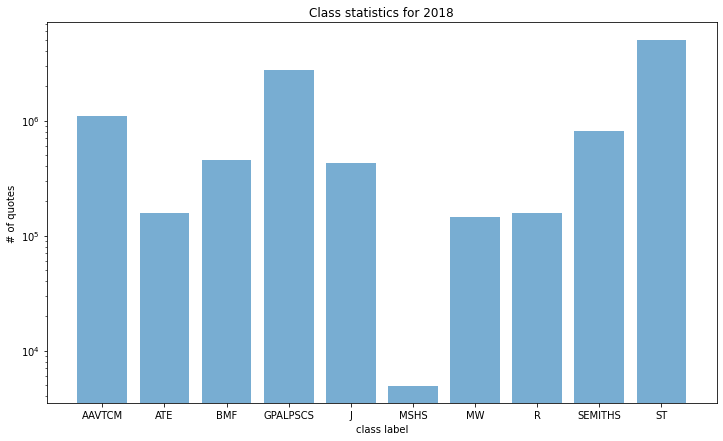

In [ ]:
#distribution for 2018
occupancy_2018 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2018.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2018, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2018')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0      AAVTCM   605860
1         ATE    86628
2         BMF   238333
3    GPALPSCS  1372329
4           J   234754
5        MSHS     3220
6          MW    81884
7           R    82334
8     SEMITHS   431659
9          ST  2936810


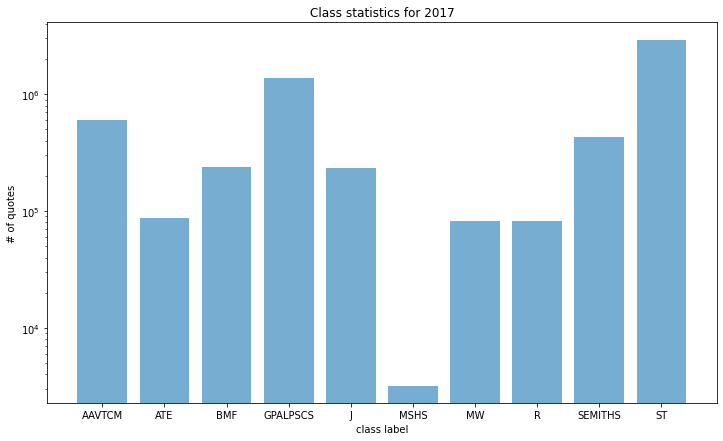

In [ ]:
#distribution for 2017
occupancy_2017 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2017.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2017, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2017')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0      AAVTCM   313942
1         ATE    46234
2         BMF   126220
3    GPALPSCS   672496
4           J   119892
5        MSHS     1563
6          MW    41831
7           R    42758
8     SEMITHS   223744
9          ST  1577815


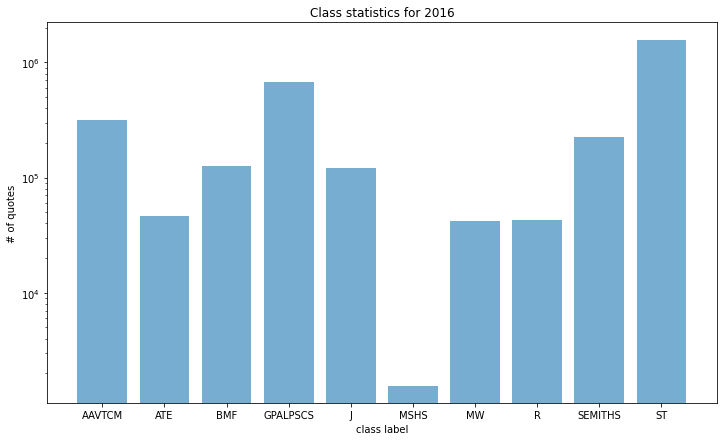

In [ ]:
#distribution for 2016
occupancy_2016 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2016.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2016, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2016')
print('--------------------------------')
print(stats_year)

Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
Currently working on new 500000...
end
--------------------------------
  class_label     qids
0      AAVTCM   473625
1         ATE    68957
2         BMF   206504
3    GPALPSCS   992035
4           J   186491
5        MSHS     2450
6          MW    59294
7           R    65917
8     SEMITHS   338569
9          ST  2362706


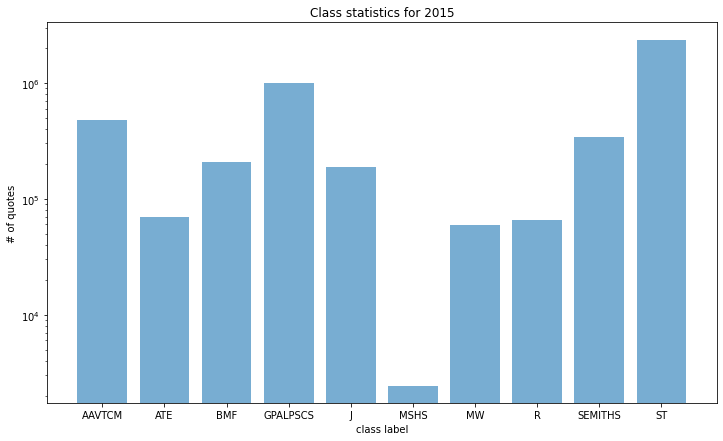

In [ ]:
#distribution for 2015
occupancy_2015 = '/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2015.csv.bz2'
stats_year['qids'] = 0
df_reader = pd.read_csv(occupancy_2015, compression='bz2', chunksize=500000)
for chunk in df_reader:
    print('Currently working on new 500000...')
    #getting chunk statistics
    stats_chunk = chunk.groupby(['class_label'])['qids'].count().to_frame().reset_index()
    #adding it to the year one
    stats_year['qids'] = stats_year['qids'] + stats_chunk['qids']
    print('end')

stats_global['qids'] = stats_global['qids'] + stats_year['qids']

#plotting the distribution
plt.subplots(figsize=(12,7))
plt.bar(stats_year.class_label, stats_year.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for 2015')
print('--------------------------------')
print(stats_year)

  class_label      qids
0      AAVTCM   3105402
1         ATE    440804
2         BMF   1279491
3    GPALPSCS   7361740
4           J   1207079
5        MSHS     14935
6          MW    408886
7           R    431509
8     SEMITHS   2279195
9          ST  14622573
--------------------------------


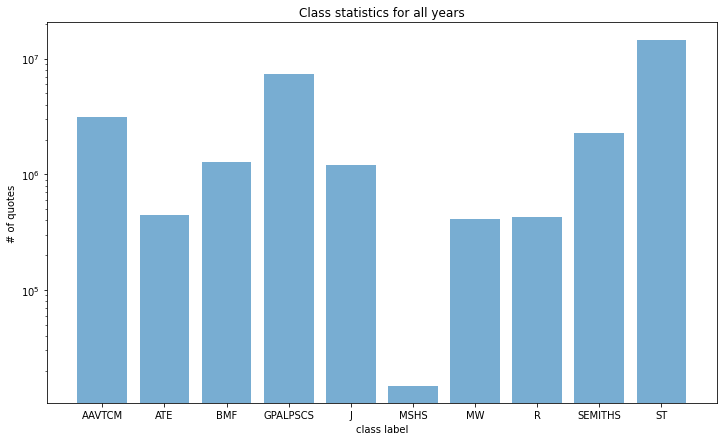

In [ ]:
#plotting the stats through all the years
plt.subplots(figsize=(12,7))
plt.bar(stats_global.class_label, stats_global.qids, alpha=0.6, log = True)
plt.xlabel('class label')
plt.ylabel('# of quotes')
plt.title('Class statistics for all years')
print(stats_global)
print('--------------------------------')

Distribution of quotes length check:

Text(0.5, 1.0, 'Quotes length distribution in 2020')

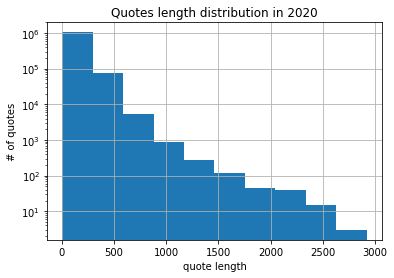

In [ ]:
#plot distribution of quotes length for 2020
check_2020 = pd.read_csv('/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2020.csv.bz2')
check_2020['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2020')

In [ ]:
#percentage of quotes with >50 characters
check_2020[check_2020['quotation'].str.len() > 50].shape[0] /\
check_2020.shape[0]

0.8568534151957022

Text(0.5, 1.0, 'Quotes length distribution in 2019')

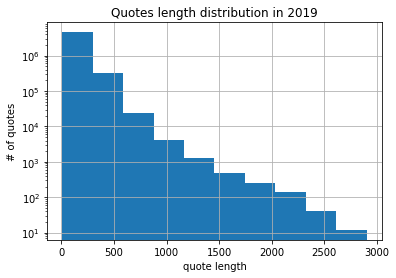

In [ ]:
#plot distribution of quotes length for 2019
check_2019 = pd.read_csv('/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2019.csv.bz2')
check_2019['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2019')

In [ ]:
#percentage of quotes with >50 characters
check_2019[check_2019['quotation'].str.len() > 50].shape[0] /\
check_2019.shape[0]

0.8512053005459023

Text(0.5, 1.0, 'Quotes length distribution in 2016')

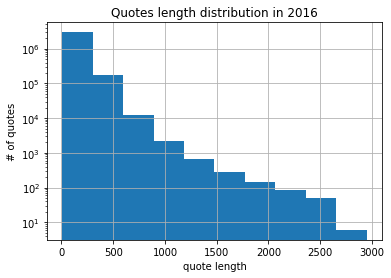

In [ ]:
#plot distribution of quotes length for 2016
check_2016 = pd.read_csv('/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2016.csv.bz2')
check_2016['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2016')

In [ ]:
#percentage of quotes with >50 characters
check_2016[check_2016['quotation'].str.len() > 50].shape[0] /\
check_2016.shape[0]

0.8315907651835863

In [ ]:
#memory cleaning
check_2020 = pd.DataFrame()
check_2019 = pd.DataFrame()
check_2016 = pd.DataFrame()
del [[check_2019, check_2016, check_2020]]
gc.collect()

3695

Text(0.5, 1.0, 'Quotes length distribution in 2015')

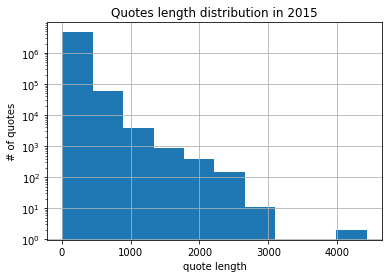

In [ ]:
#plot distribution of quotes length for 2015
check_2015 = pd.read_csv('/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2015.csv.bz2')
check_2015['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2015')

In [ ]:
#percentage of quotes with >50 characters
check_2015[check_2015['quotation'].str.len() > 50].shape[0] /\
check_2015.shape[0]

0.8309103576795609

In [ ]:
#memory cleaning
check_2015 = pd.DataFrame()
del [[check_2015]]
gc.collect()

3200

Text(0.5, 1.0, 'Quotes length distribution in 2017')

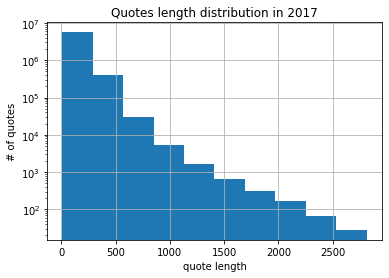

In [ ]:
#plot distribution of quotes length for 2017
check_2017 = pd.read_csv('/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2017.csv.bz2')
check_2017['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2017')

In [ ]:
#percentage of quotes with >50 characters
check_2017[check_2017['quotation'].str.len() > 50].shape[0] /\
check_2017.shape[0]

0.8366569193542571

In [ ]:
#memory cleaning
check_2017 = pd.DataFrame()
del [[check_2017]]
gc.collect()

3183

Text(0.5, 1.0, 'Quotes length distribution in 2018')

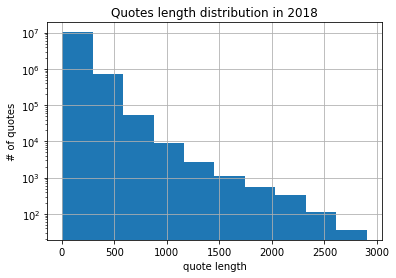

In [ ]:
#plot distribution of quotes length for 2018
check_2018 = pd.read_csv('/content/drive/MyDrive/Merged_10_2/filtered_occupancy_2018.csv.bz2')
check_2018['quotation'].str.len().hist(log=True)
plt.xlabel('quote length')
plt.ylabel('# of quotes')
plt.title('Quotes length distribution in 2018')

In [ ]:
#percentage of quotes with >50 characters
check_2018[check_2018['quotation'].str.len() > 50].shape[0] /\
check_2018.shape[0]

0.8469397105708452

In [ ]:
#memory cleaning
check_2018 = pd.DataFrame()
del [[check_2018]]
gc.collect()

5243

After this analysis we may see that it's fine to take quotations containing more than fifty characters as they represent approximately 84% of the data.

Unfortunately, this clusterisation was made only a day before the deadline, so we didn't have time to train our model on it as it'll take more than 24hrs to do so. But I think, we will still try to do after submission to check how will it improve or decrease our results.